# Classic

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import datetime
from sklearn.metrics import r2_score
import numpy as np
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
import seaborn as sns

from tst import Transformer
from tst.loss import OZELoss
import os
import pandas as pd
import torch.nn as nn

from src.dataset import OzeDataset
from src.utils import compute_loss
from src.visualization import map_plot_function, plot_values_distribution, plot_error_distribution, plot_errors_threshold, plot_visual_sample

In [3]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [25]:
# Training parameters
DATASET_PATH = '/share/data/willett-group/energy_data/data_gen_original.npz' #'datasets/dataset_57M.npz'
# BATCH_SIZE = 8
# NUM_WORKERS = 0
# LR = 2e-4
# EPOCHS = 30

# # Model parameters
# d_model = 64 # Lattent dim
# q = 8 # Query size
# v = 8 # Value size
# h = 8 # Number of heads
# N = 4 # Number of encoder and decoder to stack
# attention_size = 12 # Attention window size
# dropout = 0.2 # Dropout rate
# pe = None # Positional encoding
# chunk_mode = None

# d_input = 27 # From dataset
# d_output = 8 # From dataset

BATCH_SIZE = 8
NUM_WORKERS = 0
LR = 2e-4
EPOCHS = 30

# Model parameters
d_model = 64 # Lattent dim
q = 8 # Query size
v = 8 # Value size
h = 8 # Number of heads
N = 4 # Number of encoder and decoder to stack
attention_size = 10 # Attention window size
dropout = 0.2 # Dropout rate
pe = 'original' # Positional encoding
chunk_mode = None

d_input = 37 # From dataset
d_output = 8 # From dataset

In [4]:
torch.cuda.is_available()

True

In [7]:
# Config
# sns.set()
# device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
# print(f"Using device {device}")

## Training

### Load dataset

In [5]:
path = '/share/data/willett-group/'


us_mask = pd.DataFrame(pd.read_hdf(path + 'us_mask.h5'))
# This block is to put all nearby sst data together in time order
# And also transform data into time order (single location\)
y_samp = pd.Series()
X_total = []

# !!! 2014-2019

for i in range(2014,2019):
    print('precip.'+str(i)+'.h5')
    name_precip = 'precip.'+str(i)+'.h5'
    name_sst = 'sst.'+str(i)+'.h5' 
    name_hgt = 'hgt500.'+str(i)+'.h5'
    name_rhum = 'rhum.sig995.'+str(i)+'.h5'
    name_tmp2m = 'tmp2m.'+str(i)+'.h5'
    fileloc_precip = path + name_precip
    fileloc_sst = path + name_sst
    fileloc_hgt = path + name_hgt
    fileloc_rhum = path + name_rhum
    fileloc_tmp2m = path + name_tmp2m
    precip = pd.DataFrame(pd.read_hdf(fileloc_precip)).reset_index() # precipitation
    precip.columns = ['lat', 'lon', 'start_date', 'precip']
    sst = pd.DataFrame(pd.read_hdf(fileloc_sst)).reset_index() # Daily sea surface temperature
    sst.columns = ['lat', 'lon', 'start_date', 'sst']
    hgt = pd.DataFrame(pd.read_hdf(fileloc_hgt)).reset_index() # Daily geopotential height at 10mb and 500mb
    hgt.columns = ['lat', 'lon', 'start_date', 'hgt']
    rhum = pd.DataFrame(pd.read_hdf(fileloc_rhum)).reset_index() # Daily relative humidity near the surface
    rhum.columns = ['lat', 'lon', 'start_date', 'rhum']
    tmp2m = pd.DataFrame(pd.read_hdf(fileloc_tmp2m)).reset_index() # Daily average temperature at 2 meters
    tmp2m.columns = ['lat', 'lon', 'start_date', 'tmp2m']
    print('original', tmp2m.shape)
    
    precip = pd.merge(precip, us_mask, on=['lat','lon'])
    hgt = pd.merge(hgt, us_mask, on=['lat','lon'])
    rhum = pd.merge(rhum, us_mask, on=['lat','lon'])
    tmp2m = pd.merge(tmp2m, us_mask, on=['lat','lon'])
    print('after merge', tmp2m.shape)
    
    hgt = np.reshape(hgt[(hgt['lat']==25.25) & (hgt['lon']==279.25)].hgt.to_numpy(),(-1,1))
    rhum = np.reshape(rhum[(rhum['lat']==25.25) & (rhum['lon']==279.25)].rhum.to_numpy(),(-1,1))
    tmp2m = np.reshape(tmp2m[(tmp2m['lat']==25.25) & (tmp2m['lon']==279.25)].tmp2m.to_numpy(),(-1,1))
    print('one location', tmp2m.shape)
    
    y_samp = y_samp.append(precip[precip['lat']==25.25].precip,ignore_index=True)
    
    if i%4 == 0:
        days = 366
    else:
        days = 365
    temp = sst[(sst['lat']>=24.25) & (sst['lat']<=26.25) & (sst['lon']>=278.25) & (sst['lon']<=280.25)]
    sst_samp = temp.sst.reset_index().sst.to_numpy()
    size = int(len(sst_samp)/days)
    sst_samp = np.reshape(sst_samp,(size, days)).transpose() # days as rows, different locations as columns
    all_features = np.concatenate((sst_samp,hgt,rhum,tmp2m),axis=1)
    print('all_features', all_features.shape)
    X_total.append(all_features)
    
X_size = X_total[0].shape[1]
X_samp = np.zeros((1,X_size)) #  For concatenating all data
print(X_samp.shape)
for i in range(len(X_total)):
    X_samp = np.concatenate((X_samp,X_total[i]),axis = 0)
X_samp = X_samp[1:]
print(X_samp.shape)

<ipython-input-5-2c2128848061>:7: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  y_samp = pd.Series()


precip.2014.h5
original (1201945, 4)
after merge (1195010, 4)
one location (365, 1)
all_features (365, 19)
precip.2015.h5
original (1201945, 4)
after merge (1195010, 4)
one location (365, 1)
all_features (365, 19)
precip.2016.h5
original (1205238, 4)
after merge (1198284, 4)
one location (366, 1)
all_features (366, 19)
precip.2017.h5
original (1201945, 4)
after merge (1195010, 4)
one location (365, 1)
all_features (365, 19)
precip.2018.h5
original (1201945, 4)
after merge (1195010, 4)
one location (365, 1)
all_features (365, 19)
(1, 19)
(1826, 19)


In [6]:
X_copy = X_samp.copy()
y_copy = y_samp.copy()

In [7]:
y_copy[:10]

0    0.231702
1    0.041115
2    0.133239
3    0.000000
4    2.492696
5    0.410681
6    2.943203
7    0.183489
8    1.798745
9    0.043239
dtype: float32

In [8]:
X_samp[:10, -1]

array([24.5952034 , 24.56220818, 18.64498901, 19.82747078, 23.55850029,
       20.56591797, 11.40529251, 15.68605709, 22.65063095, 23.57511902])

In [9]:
X_samp = X_copy.copy()
y_samp = y_copy.copy()
target = 'precip'

In [10]:
y_samp = X_copy[:,X_copy.shape[1]-1].copy()
X_samp[:,X_copy.shape[1]-1] = y_copy.copy()
target = 'tmp2m'

In [11]:
y_samp[:10]

array([24.5952034 , 24.56220818, 18.64498901, 19.82747078, 23.55850029,
       20.56591797, 11.40529251, 15.68605709, 22.65063095, 23.57511902])

In [12]:
X_samp[:10, -1]

array([0.23170176, 0.04111537, 0.13323852, 0.        , 2.49269629,
       0.41068092, 2.94320297, 0.1834887 , 1.79874539, 0.04323921])

In [13]:
X_samp.shape, y_samp.shape

((1826, 19), (1826,))

In [14]:
# Calculate moving average for tmp
avg_window = 14
y_movavg = []
X_movavg = []
for i in range(y_samp.shape[0]-avg_window):
    y_avg = np.mean(y_samp[i:i+avg_window])
    y_movavg.append(y_avg)
    X_avg = np.mean(X_samp[i:i+avg_window],axis=0)
    X_movavg.append(X_avg)
y_movavg = np.array(y_movavg)
X_movavg = np.array(X_movavg)
y_samp = y_movavg
X_samp = X_movavg

In [17]:
# Standardize data by z-scoring
# mean = np.mean(y_samp)
# std = np.std(y_samp)
# y_samp = (y_samp-mean)/std
# X_samp[:,0:16] = (X_samp[:,0:16] - np.mean(X_samp[:,0:16]))/np.std(X_samp[:,16])
# X_samp[:,16] = (X_samp[:,16] - np.mean(X_samp[:,16]))/np.std(X_samp[:,16])
# X_samp[:,17] = (X_samp[:,17] - np.mean(X_samp[:,17]))/np.std(X_samp[:,17])
# X_samp[:,18] = (X_samp[:,18] - np.mean(X_samp[:,18]))/np.std(X_samp[:,18])

# X = X_samp.copy()
# y = y_samp.copy()





In [15]:
M = np.max(y_samp)
m = np.min(y_samp)
y_samp = (y_samp -m)/(M - m)
X_samp[:,0:16] = (X_samp[:,0:16] - np.min(X_samp[:,0:16]))/ (np.max(X_samp[:,0:16]) - np.min(X_samp[:,0:16]))
X_samp[:,16] = (X_samp[:,16] - np.min(X_samp[:,16]))/(np.max(X_samp[:,16]) - np.min(X_samp[:,16]))
X_samp[:,17] = (X_samp[:,17] - np.min(X_samp[:,17]))/(np.max(X_samp[:,17]) - np.min(X_samp[:,17]))
X_samp[:,18] = (X_samp[:,18] - np.min(X_samp[:,18]))/(np.max(X_samp[:,18]) - np.min(X_samp[:,18]))

X = X_samp.copy()
y = y_samp.copy()

In [17]:
X_samp.max(), X_samp.min(), y.max(), y.min()

(1.0, 0.0, 1.0, 0.0)

In [18]:
X.shape, y.shape

((1812, 19), (1812,))

In [16]:
def create_sequence(input_data, train_window, pred_window):  #  Create sequences of observations for training
    seq = []
    L = len(input_data)
    feature_size = input_data[0].shape[0]
    print('feature_size', feature_size)
    for i in range(L - train_window-pred_window):
        train_seq = input_data[i:i+train_window]
        train_label = input_data[i+train_window+pred_window-1,feature_size-1] # get y_t+14
#         train_label = input_data[i + train_window + pred_window]
        seq.append((train_seq ,train_label))
        
    print('train_seq, train_label', train_seq.shape, train_label.shape)
    return seq

In [17]:
train_test_split = 0.8
test_size = int((1-train_test_split)*y_samp.shape[0])
X_train = X[:-test_size]
X_test = X[-test_size:]
y_train = y[:-test_size]
y_test = y[-test_size:]

In [18]:
y_train = np.reshape(y_train,(-1,1))  #  Matching dimension for concatenating X and y
y_test = np.reshape(y_test,(-1,1)) 
train_data_array = np.concatenate((X_train,y_train),axis=1)
train_data = torch.FloatTensor(train_data_array)
y_train = torch.FloatTensor(y_train)

In [19]:
train_data.shape, y_train.shape

(torch.Size([1450, 20]), torch.Size([1450, 1]))

In [20]:
train_window = 30
pred_window = 14
train_seq = create_sequence(train_data, train_window, pred_window)

feature_size 20
train_seq, train_label torch.Size([30, 20]) torch.Size([])


In [21]:
len(train_seq)

1406

In [22]:
from torch.utils.data import Dataset, DataLoader

class SeqDataset(Dataset):
    def __init__(self, seq_data, transform=None):
        
        self.seq_data = seq_data
        self.x = []
        self.y = []
        for i in range(len(self.seq_data)):
            self.x.append(self.seq_data[i][0])
            self.y.append(self.seq_data[i][1])

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        return (self.x[idx], self.y[idx])

    def __len__(self):
        return len(train_seq) #self._x.shape[0]

In [23]:
dataset_train = SeqDataset(train_seq)
dataloader_train = DataLoader(dataset_train,
                              batch_size=16,
                              shuffle=False,
                              num_workers=0,
                              pin_memory=False
                             )

In [27]:
ozeDataset = OzeDataset(DATASET_PATH)
# ozeDatasetLength = len(ozeDataset)

In [28]:
# ozeDatasetLength, trainSize, valSize, testSize

### Load network

In [ ]:
class Reshape(nn.Module):
    def __init__(self, *args):
        super(Reshape, self).__init__()
        self.shape = args

    def forward(self, x):
        return x.view(self.shape)

In [79]:
from torch.optim.lr_scheduler import StepLR, CosineAnnealingLR

In [81]:
# Load transformer with Adam optimizer and MSE loss function
d_input = 20 # From dataset
d_output = 1 # From dataset
attention_size = 8
LR = 1e-3 #1e-3
d_model = 64
net = Transformer(d_input, d_model, d_output, q, v, h, N, attention_size=attention_size, 
                  dropout=dropout, chunk_mode=chunk_mode, pe='regular', pe_period=2).to(device)
# net = nn.Sequential(Transformer(d_input, d_model, d_output, q, v, h, N, attention_size=attention_size, 
#                   dropout=dropout, chunk_mode=chunk_mode, pe=pe),
#                     nn.Flatten(),
#                     nn.Linear(30, 1),
#                    ).to(device)
optimizer = optim.Adam(net.parameters(), lr=LR)
loss_function = nn.MSELoss() #OZELoss(alpha=0.3)

# scheduler = CosineAnnealingLR(optimizer, 30, 0) # StepLR(optimizer, step_size=15, gamma=0.1)

In [34]:
d_input, d_model, d_output, q, v, h, N, attention_size

(20, 64, 1, 8, 8, 8, 4, 12)

In [25]:
d_input, d_model, d_output, q, v, h, N, attention_size

(37, 64, 8, 8, 8, 8, 4, 12)

In [26]:
x.shape, y.shape

(torch.Size([4, 672, 37]), torch.Size([4, 672, 8]))

### Train

In [38]:
# torch.save(net.state_dict(), 'transformer_toy.pth') # attn size 2, batch 16, lr 1e-4, 40 epochs

[Epoch  40/40]: 100%|██████████| 1406/1406 [00:08<00:00, 168.22it/s, loss=0.0539]


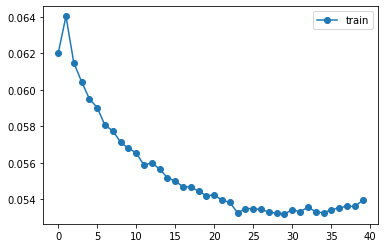

In [82]:
EPOCHS = 40
hist_loss = np.zeros(EPOCHS)
hist_loss_val = np.zeros(EPOCHS)

for idx_epoch in range(EPOCHS):
    running_loss = 0
    with tqdm(total=len(train_seq), desc=f"[Epoch {idx_epoch+1:3d}/{EPOCHS}]") as pbar:
        for idx_batch, (x, y) in enumerate(dataloader_train):
#             x = x.unsqueeze(0)
            y = y.view(-1,1)
            optimizer.zero_grad()

            # Propagate input
            netout = net(x.to(device))

            # Compute loss
#             print(netout, y)
            loss = loss_function(y.to(device), netout)

            # Backpropage loss
            loss.backward()

            # Update weights
            optimizer.step()

            running_loss += loss.item()
            pbar.set_postfix({'loss': running_loss/(idx_batch+1)})
            pbar.update(x.shape[0])
                
#         scheduler.step()    
        train_loss = running_loss/len(dataloader_train)
#         print('pred, target', netout, y)
#         val_loss = compute_loss(net, dataloader_val, loss_function, device).item()
#         pbar.set_postfix({'loss': train_loss, 'val_loss': val_loss})
        pbar.set_postfix({'loss': train_loss})

        hist_loss[idx_epoch] = train_loss
#         hist_loss_val[idx_epoch] = val_loss

#         if val_loss < val_loss_best:
#             val_loss_best = val_loss
#             torch.save(net.state_dict(), model_save_path)
        
plt.plot(hist_loss, 'o-', label='train')
# plt.plot(hist_loss_val, 'o-', label='val')
plt.legend()
# print(f"model exported to {model_save_path} with loss {val_loss_best:5f}")

In [36]:
attn_map.shape

torch.Size([30, 30])

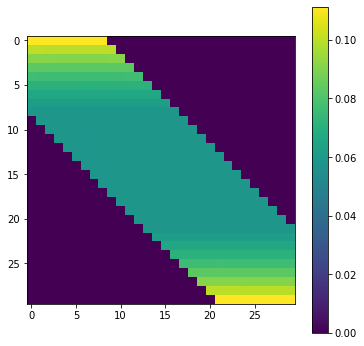

In [83]:
net.eval();
encoder = net.layers_encoding[0]

# Get the first attention map
attn_map = encoder.attention_map[0].cpu().detach().numpy()
# Plot
plt.figure(figsize=(6, 6))
plt.imshow(attn_map)
plt.colorbar();

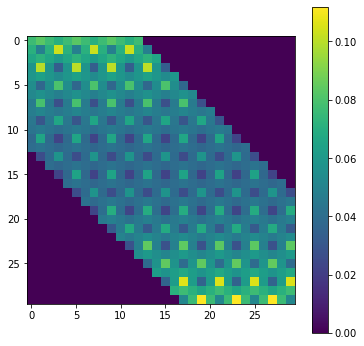

In [98]:
# Select first encoding layer
encoder = net.layers_encoding[0]

# Get the first attention map
attn_map = encoder.attention_map[0].cpu().detach().numpy()
# Plot
plt.figure(figsize=(6, 6))
plt.imshow(attn_map)
plt.colorbar();
# plt.savefig("attention_map")

In [49]:
netout.shape, y.shape

(torch.Size([1, 1]), torch.Size([1, 1]))

In [50]:
netout, y

(tensor([[0.9383]], device='cuda:0', grad_fn=<AddmmBackward>),
 tensor([[0.9732]]))

In [57]:
train_test_total.shape[0]-train_window

321

In [84]:
# Predicting t+1
test_data = np.concatenate((X_test,y_test),axis=1)

train_test_total = np.concatenate((train_data_array,test_data))

net.eval()
num_pred = 1 #  Number of prediction forward, i.e. tau
res = np.zeros(train_window).tolist()
#  Predicting y using X_test and y_test
for i in tqdm(range(train_test_total.shape[0]-train_window)):
    for j in range(num_pred):
        seq = torch.FloatTensor(train_test_total[i:i+train_window]).to(device)
        seq = seq.unsqueeze(0)
        #print(seq)
        with torch.no_grad():
            #print(model(seq))
            pred = net(seq).cpu()
            #print(len(test_inputs))
            res.append(pred)
            
res = np.array(res)

100%|██████████| 1782/1782 [00:30<00:00, 57.84it/s]


r-sq on train: -0.004202037393223668
r-sq on test: -0.02655463018724502


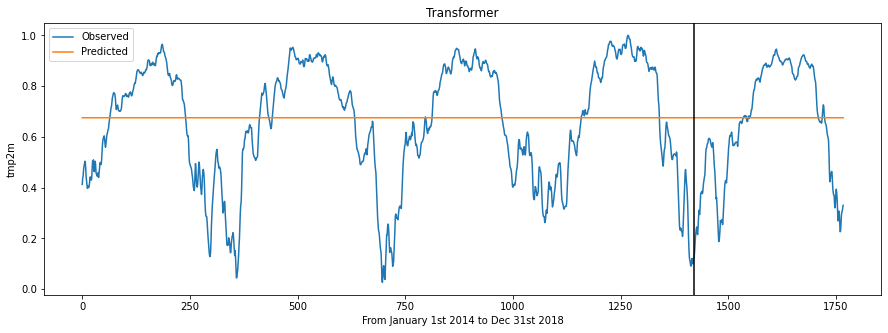

In [78]:
y_train = y_train.cpu()
from sklearn.metrics import r2_score
print('r-sq on train:', r2_score(y_samp[train_window+pred_window:-test_size], res[train_window:-test_size-pred_window]))
print('r-sq on test:', r2_score(y_samp[-test_size:],  res[-test_size-pred_window:-pred_window]))
plt.figure(figsize=(15,5))
plt.plot(y_samp[train_window+pred_window:],label='Observed')
plt.plot(res[train_window:-pred_window],label='Predicted')
plt.legend()
plt.xlabel('From January 1st 2014 to Dec 31st 2018')
plt.ylabel(target)
plt.title('Transformer')
plt.axvline(x=res.shape[0] - test_size-train_window,c='black')
# plt.savefig('plot_toy_pe2_atten8_depth60.pdf')

In [63]:
# torch.save(net.to('cpu'), 'full_transformer_toy_pe2_attn8_depth60.pth')

In [31]:
# model = torch.load('full_transformer_toy_pe2_attn8.pth')

In [33]:
model.to(device);
test_data = np.concatenate((X_test,y_test),axis=1)

train_test_total = np.concatenate((train_data_array,test_data))

net.eval()
num_pred = 1 #  Number of prediction forward, i.e. tau
res = np.zeros(train_window).tolist()
#  Predicting y using X_test and y_test
for i in tqdm(range(train_test_total.shape[0]-train_window)):
    for j in range(num_pred):
        seq = torch.FloatTensor(train_test_total[i:i+train_window]).to(device)
        seq = seq.unsqueeze(0)
        #print(seq)
        with torch.no_grad():
            #print(model(seq))
            pred = model(seq).cpu()
            #print(len(test_inputs))
            res.append(pred)
            
res = np.array(res)

r-sq on train: 0.8381050745924563
r-sq on test: 0.7280171298443501


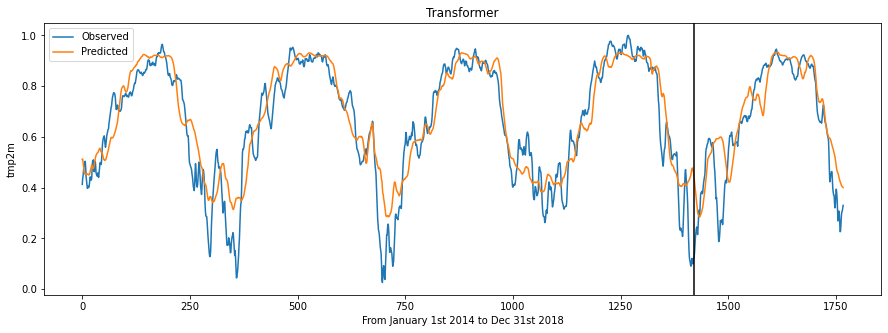

In [35]:
y_train = y_train.cpu()
from sklearn.metrics import r2_score
print('r-sq on train:', r2_score(y_samp[train_window+pred_window:-test_size], res[train_window:-test_size-pred_window]))
print('r-sq on test:', r2_score(y_samp[-test_size:],  res[-test_size-pred_window:-pred_window]))
plt.figure(figsize=(15,5))
plt.plot(y_samp[train_window+pred_window:],label='Observed')
plt.plot(res[train_window:-pred_window],label='Predicted')
plt.legend()
plt.xlabel('From January 1st 2014 to Dec 31st 2018')
plt.ylabel(target)
plt.title('Transformer')
plt.axvline(x=res.shape[0] - test_size-train_window,c='black')

In [93]:
res.shape

(351,)

In [94]:
res[100]

0.7870141863822937

r-sq on train: 0.8193675238715779
r-sq on test: 0.648727789484095


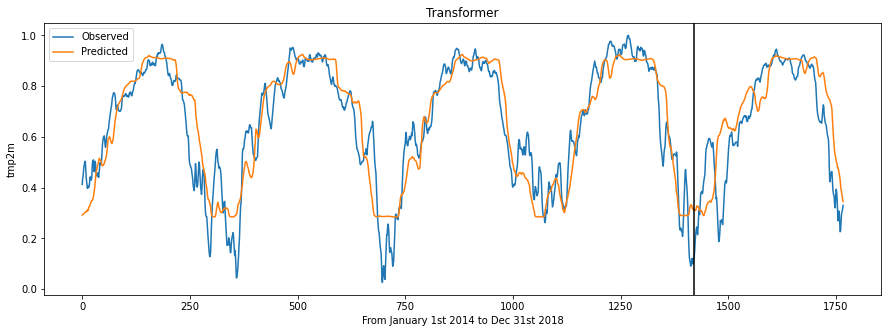

In [100]:
y_train = y_train.cpu()
from sklearn.metrics import r2_score
print('r-sq on train:', r2_score(y_samp[train_window+pred_window:-test_size], res[train_window:-test_size-pred_window]))
print('r-sq on test:', r2_score(y_samp[-test_size:],  res[-test_size-pred_window:-pred_window]))
plt.figure(figsize=(15,5))
plt.plot(y_samp[train_window+pred_window:],label='Observed')
plt.plot(res[train_window:-pred_window],label='Predicted')
plt.legend()
plt.xlabel('From January 1st 2014 to Dec 31st 2018')
plt.ylabel(target)
plt.title('Transformer')
plt.axvline(x=res.shape[0] - test_size-train_window,c='black')

r-sq on train: 0.8381050745924563
r-sq on test: 0.7280171298443501


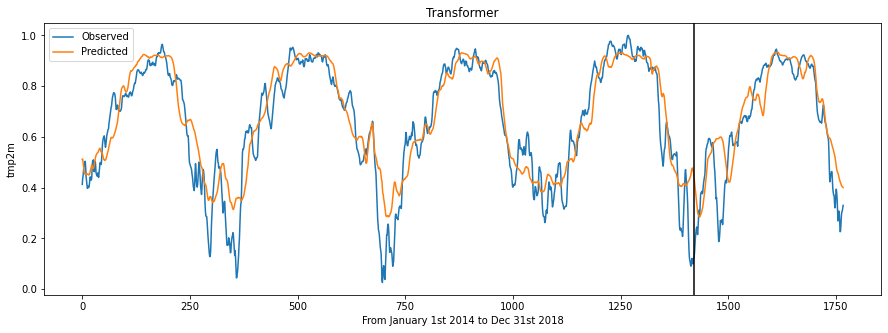

In [69]:
y_train = y_train.cpu()
from sklearn.metrics import r2_score
print('r-sq on train:', r2_score(y_samp[train_window+pred_window:-test_size], res[train_window:-test_size-pred_window]))
print('r-sq on test:', r2_score(y_samp[-test_size:],  res[-test_size-pred_window:-pred_window]))
plt.figure(figsize=(15,5))
plt.plot(y_samp[train_window+pred_window:],label='Observed')
plt.plot(res[train_window:-pred_window],label='Predicted')
plt.legend()
plt.xlabel('From January 1st 2014 to Dec 31st 2018')
plt.ylabel(target)
plt.title('Transformer')
plt.axvline(x=res.shape[0] - test_size-train_window,c='black')
# plt.savefig('plot_toy_toy6_pe2_atten8.pdf')

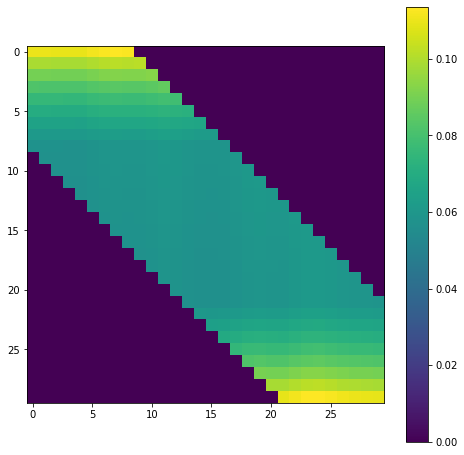

In [70]:
encoder = net.layers_encoding[0]

# Get the first attention map
attn_map = encoder.attention_map[0].cpu().detach().numpy()
# Plot
plt.figure(figsize=(8, 8))
plt.imshow(attn_map)
plt.colorbar();
# plt.savefig("attention_map")

In [71]:
# torch.save(net.to('cpu'), 'full_transformer_toy_pe2_attn8.pth')

In [ ]:
# Select first encoding layer
encoder = net.layers_encoding[0]

# Get the first attention map
attn_map = encoder.attention_map[0].cpu()

# Plot
plt.figure(figsize=(20, 20))
sns.heatmap(attn_map)
plt.savefig("attention_map")

r-sq on train: 0.7945251760991355
r-sq on test: 0.5217658095875849


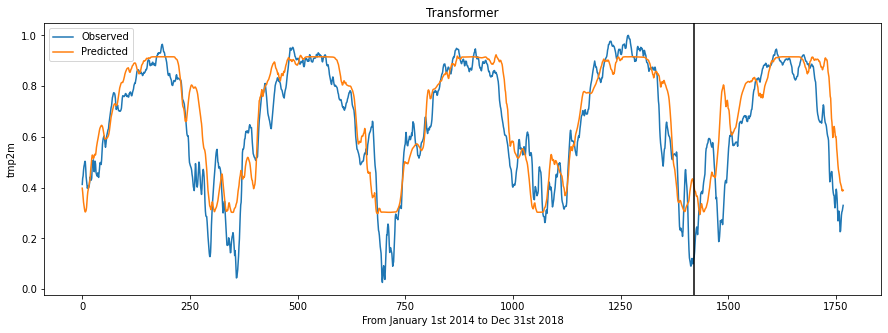

In [36]:
y_train = y_train.cpu()
from sklearn.metrics import r2_score
print('r-sq on train:', r2_score(y_samp[train_window+pred_window:-test_size], res[train_window:-test_size-pred_window]))
print('r-sq on test:', r2_score(y_samp[-test_size:],  res[-test_size-pred_window:-pred_window]))
plt.figure(figsize=(15,5))
plt.plot(y_samp[train_window+pred_window:],label='Observed')
plt.plot(res[train_window:-pred_window],label='Predicted')
plt.legend()
plt.xlabel('From January 1st 2014 to Dec 31st 2018')
plt.ylabel(target)
plt.title('Transformer')
plt.axvline(x=res.shape[0] - test_size-train_window,c='black')
# plt.savefig('plot_toy_toy4.pdf')

r-sq on train: 0.7945251760991355
r-sq on test: 0.5217658095875849


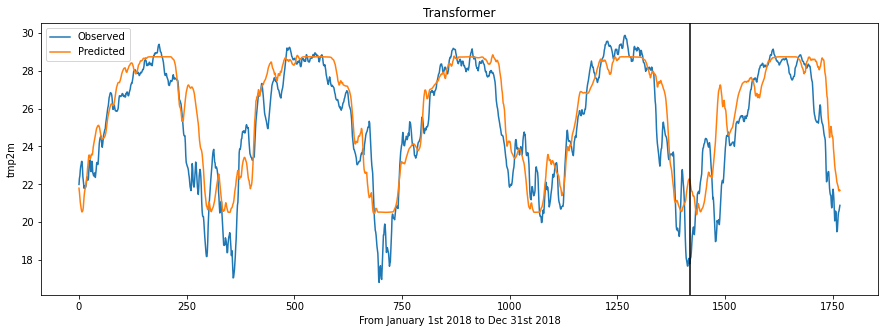

In [37]:
y_train = y_train.cpu()
from sklearn.metrics import r2_score
print('r-sq on train:', r2_score(y_samp[train_window+pred_window:-test_size], res[train_window:-test_size-pred_window]))
print('r-sq on test:', r2_score(y_samp[-test_size:],  res[-test_size-pred_window:-pred_window]))
plt.figure(figsize=(15,5))
plt.plot(y_samp[train_window+pred_window:]*(M - m) + m,label='Observed')
plt.plot(res[train_window:-pred_window]*(M - m) + m,label='Predicted')
plt.legend()
plt.xlabel('From January 1st 2018 to Dec 31st 2018')
plt.ylabel(target)
plt.title('Transformer')
plt.axvline(x=res.shape[0] - test_size-train_window,c='black')

In [86]:
seq_data = []
for i in tqdm(range(train_test_total.shape[0]-train_window)):
    for j in range(num_pred):
        seq_data.append(train_test_total[i:i+train_window])

100%|██████████| 321/321 [00:00<00:00, 315014.41it/s]


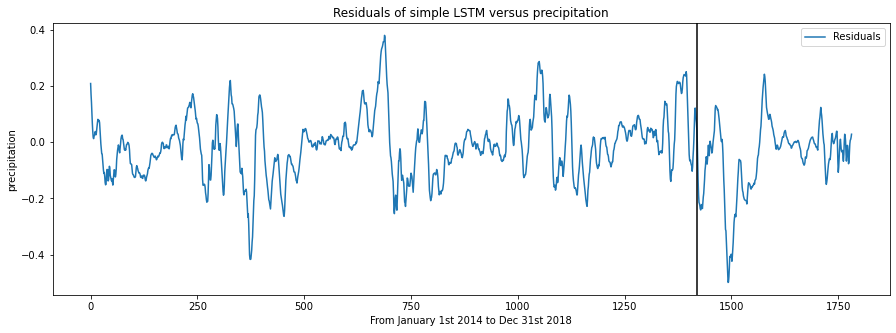

In [95]:
plt.figure(figsize=(15,5))
plt.plot(y_samp[train_window:] - res[train_window:] ,label='Residuals')
plt.legend()
plt.xlabel('From January 1st 2014 to Dec 31st 2018')
plt.ylabel('precipitation')
plt.title('Residuals of simple LSTM versus precipitation')
plt.axvline(x=res.shape[0] - test_size-train_window,c='black')

In [88]:
len(seq_data)

321

In [91]:
seq_data[0].shape

(30, 20)

In [114]:
from torch.utils.data import Dataset, DataLoader

class SeqTestDataset(Dataset):
    def __init__(self, seq_data, transform=None):
        
        self.seq_data = seq_data
        self.x = []
        self.y = []
        for i in range(len(self.seq_data)):
#             self.x.append(self.seq_data[i][0])
            self.y.append(self.seq_data[i])

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        return (np.random.randn(1), self.y[idx])

    def __len__(self):
        return len(train_seq) #self._x.shape[0]

In [115]:
test_dataset = SeqTestDataset(seq_data)
test_dataloader = DataLoader(test_dataset,
                              batch_size=8,
                              shuffle=False,
                              num_workers=0,
                              pin_memory=False
                             )

In [116]:
for _, seq in test_dataloader:
    break

In [117]:
seq.shape

torch.Size([8, 30, 20])

In [118]:
# net(seq.double())

In [120]:
seq.shape

torch.Size([1, 8, 30, 20])

In [123]:
# # Predicting t+1
# test_data = np.concatenate((X_test,y_test),axis=1)

# train_test_total = np.concatenate((train_data_array,test_data))

net.eval()
# num_pred = 1 #  Number of prediction forward, i.e. tau
# res = np.zeros(train_window).tolist()
#  Predicting y using X_test and y_test
for _, seq in test_dataloader:
    for j in range(num_pred):
        seq = seq.to(device)
        #print(seq)
        with torch.no_grad():
            #print(model(seq))
            pred = net(seq.double()).cpu()
            #print(len(test_inputs))
            res.append(pred)
res = np.array(res)

RuntimeError: expected scalar type Double but found Float

In [84]:
# Predicting t+1
test_data = np.concatenate((X_test,y_test),axis=1)

train_test_total = np.concatenate((train_data_array,test_data))

net.eval()
num_pred = 1 #  Number of prediction forward, i.e. tau
res = np.zeros(train_window).tolist()
#  Predicting y using X_test and y_test
for i in tqdm(range(train_test_total.shape[0]-train_window)):
    for j in range(num_pred):
        seq = torch.FloatTensor(train_test_total[i:i+train_window]).to(device)
        seq = seq.unsqueeze(0)
        #print(seq)
        with torch.no_grad():
            #print(model(seq))
            pred = net(seq).cpu()
            #print(len(test_inputs))
            res.append(pred)
res = np.array(res)

100%|██████████| 321/321 [00:05<00:00, 58.84it/s]


In [52]:
seq.shape

torch.Size([1, 30, 20])

In [53]:
res.shape

(351,)

In [56]:
# res[train_window:-pred_window]

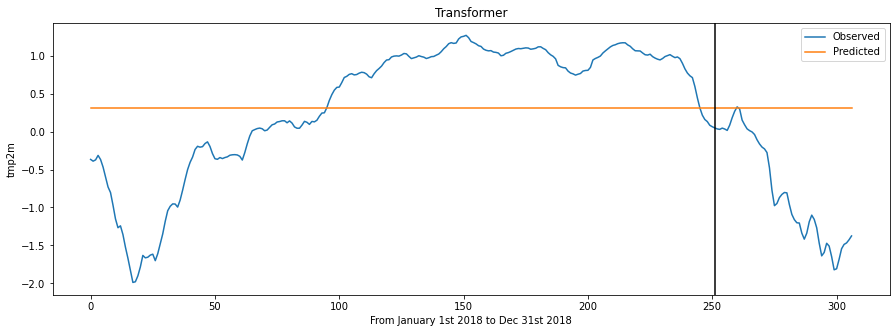

In [85]:
y_train = y_train.cpu()

# print('r-sq on train:', r2_score(y_samp[train_window+pred_window:-test_size], res[train_window:-test_size-pred_window]))
# print('r-sq on test:', r2_score(y_samp[-test_size:],  res[-test_size-pred_window:-pred_window]))
plt.figure(figsize=(15,5))
plt.plot(y_samp[train_window+pred_window:],label='Observed')
plt.plot(res[train_window:-pred_window],label='Predicted')
plt.legend()
plt.xlabel('From January 1st 2018 to Dec 31st 2018')
plt.ylabel(target)
plt.title('Transformer')
plt.axvline(x=res.shape[0] - test_size-train_window,c='black')
# plt.savefig('plot_toy_toy1.pdf')

[Epoch  30/30]: 100%|██████████| 5500/5500 [02:45<00:00, 33.32it/s, loss=0.000745, val_loss=0.000727]


model exported to models/model_2021_01_14__124614.pth with loss 0.000727


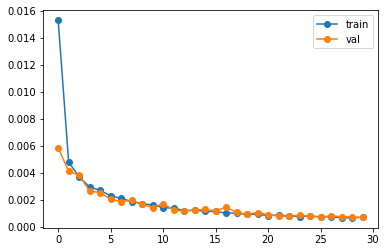

In [31]:
model_save_path = f'models/model_{datetime.datetime.now().strftime("%Y_%m_%d__%H%M%S")}.pth'
val_loss_best = np.inf

# Prepare loss history
hist_loss = np.zeros(EPOCHS)
hist_loss_val = np.zeros(EPOCHS)
for idx_epoch in range(EPOCHS):
    running_loss = 0
    with tqdm(total=len(dataloader_train.dataset), desc=f"[Epoch {idx_epoch+1:3d}/{EPOCHS}]") as pbar:
        for idx_batch, (x, y) in enumerate(dataloader_train):
            optimizer.zero_grad()

            # Propagate input
            netout = net(x.to('cuda'))

            # Compute loss
            loss = loss_function(y.to('cuda'), netout)

            # Backpropage loss
            loss.backward()

            # Update weights
            optimizer.step()

            running_loss += loss.item()
            pbar.set_postfix({'loss': running_loss/(idx_batch+1)})
            pbar.update(x.shape[0])
        
        train_loss = running_loss/len(dataloader_train)
        val_loss = compute_loss(net, dataloader_val, loss_function, 'cuda').item()
        pbar.set_postfix({'loss': train_loss, 'val_loss': val_loss})
        
        hist_loss[idx_epoch] = train_loss
        hist_loss_val[idx_epoch] = val_loss
        
        if val_loss < val_loss_best:
            val_loss_best = val_loss
            torch.save(net.state_dict(), model_save_path)
        
plt.plot(hist_loss, 'o-', label='train')
plt.plot(hist_loss_val, 'o-', label='val')
plt.legend()
print(f"model exported to {model_save_path} with loss {val_loss_best:5f}")

[Epoch  30/30]: 100%|██████████| 23000/23000 [05:04<00:00, 75.50it/s, loss=9.13e-5, val_loss=0.000107]


model exported to models/model_2020_06_27__062220.pth with loss 0.000102


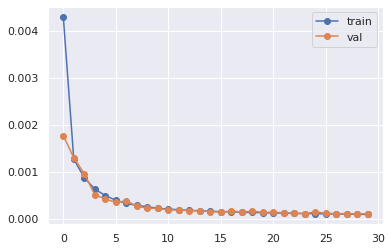

In [6]:
model_save_path = f'models/model_{datetime.datetime.now().strftime("%Y_%m_%d__%H%M%S")}.pth'
val_loss_best = np.inf

# Prepare loss history
hist_loss = np.zeros(EPOCHS)
hist_loss_val = np.zeros(EPOCHS)
for idx_epoch in range(EPOCHS):
    running_loss = 0
    with tqdm(total=len(dataloader_train.dataset), desc=f"[Epoch {idx_epoch+1:3d}/{EPOCHS}]") as pbar:
        for idx_batch, (x, y) in enumerate(dataloader_train):
            optimizer.zero_grad()

            # Propagate input
            netout = net(x.to(device))

            # Comupte loss
            loss = loss_function(y.to(device), netout)

            # Backpropage loss
            loss.backward()

            # Update weights
            optimizer.step()

            running_loss += loss.item()
            pbar.set_postfix({'loss': running_loss/(idx_batch+1)})
            pbar.update(x.shape[0])
        
        train_loss = running_loss/len(dataloader_train)
        val_loss = compute_loss(net, dataloader_val, loss_function, device).item()
        pbar.set_postfix({'loss': train_loss, 'val_loss': val_loss})
        
        hist_loss[idx_epoch] = train_loss
        hist_loss_val[idx_epoch] = val_loss
        
        if val_loss < val_loss_best:
            val_loss_best = val_loss
            torch.save(net.state_dict(), model_save_path)
        
plt.plot(hist_loss, 'o-', label='train')
plt.plot(hist_loss_val, 'o-', label='val')
plt.legend()
print(f"model exported to {model_save_path} with loss {val_loss_best:5f}")

## Validation

In [32]:
_ = net.eval()

### Evaluate on the test dataset

In [35]:
netout.shape

(8, 672, 8)

In [36]:
print(idx_prediction, idx_prediction+x.shape[0])

0 8


In [57]:
predictions.shape, netout.shape, x.shape

((1000, 168, 8), (8, 672, 8), torch.Size([8, 672, 37]))

In [54]:
predictions[0].shape

(168, 8)

In [56]:
predictions[10:15].shape

(5, 168, 8)

In [59]:
predictions = np.empty(shape=(len(dataloader_test.dataset), 672, 8))
# predictions = np.empty(shape=(len(dataloader_test.dataset), 168, 8))

idx_prediction = 0
with torch.no_grad():
    for x, y in tqdm(dataloader_test, total=len(dataloader_test)):
        netout = net(x.to('cuda')).cpu().numpy()
        predictions[idx_prediction:idx_prediction+x.shape[0]] = netout
        idx_prediction += x.shape[0]

100%|██████████| 125/125 [00:10<00:00, 11.55it/s]


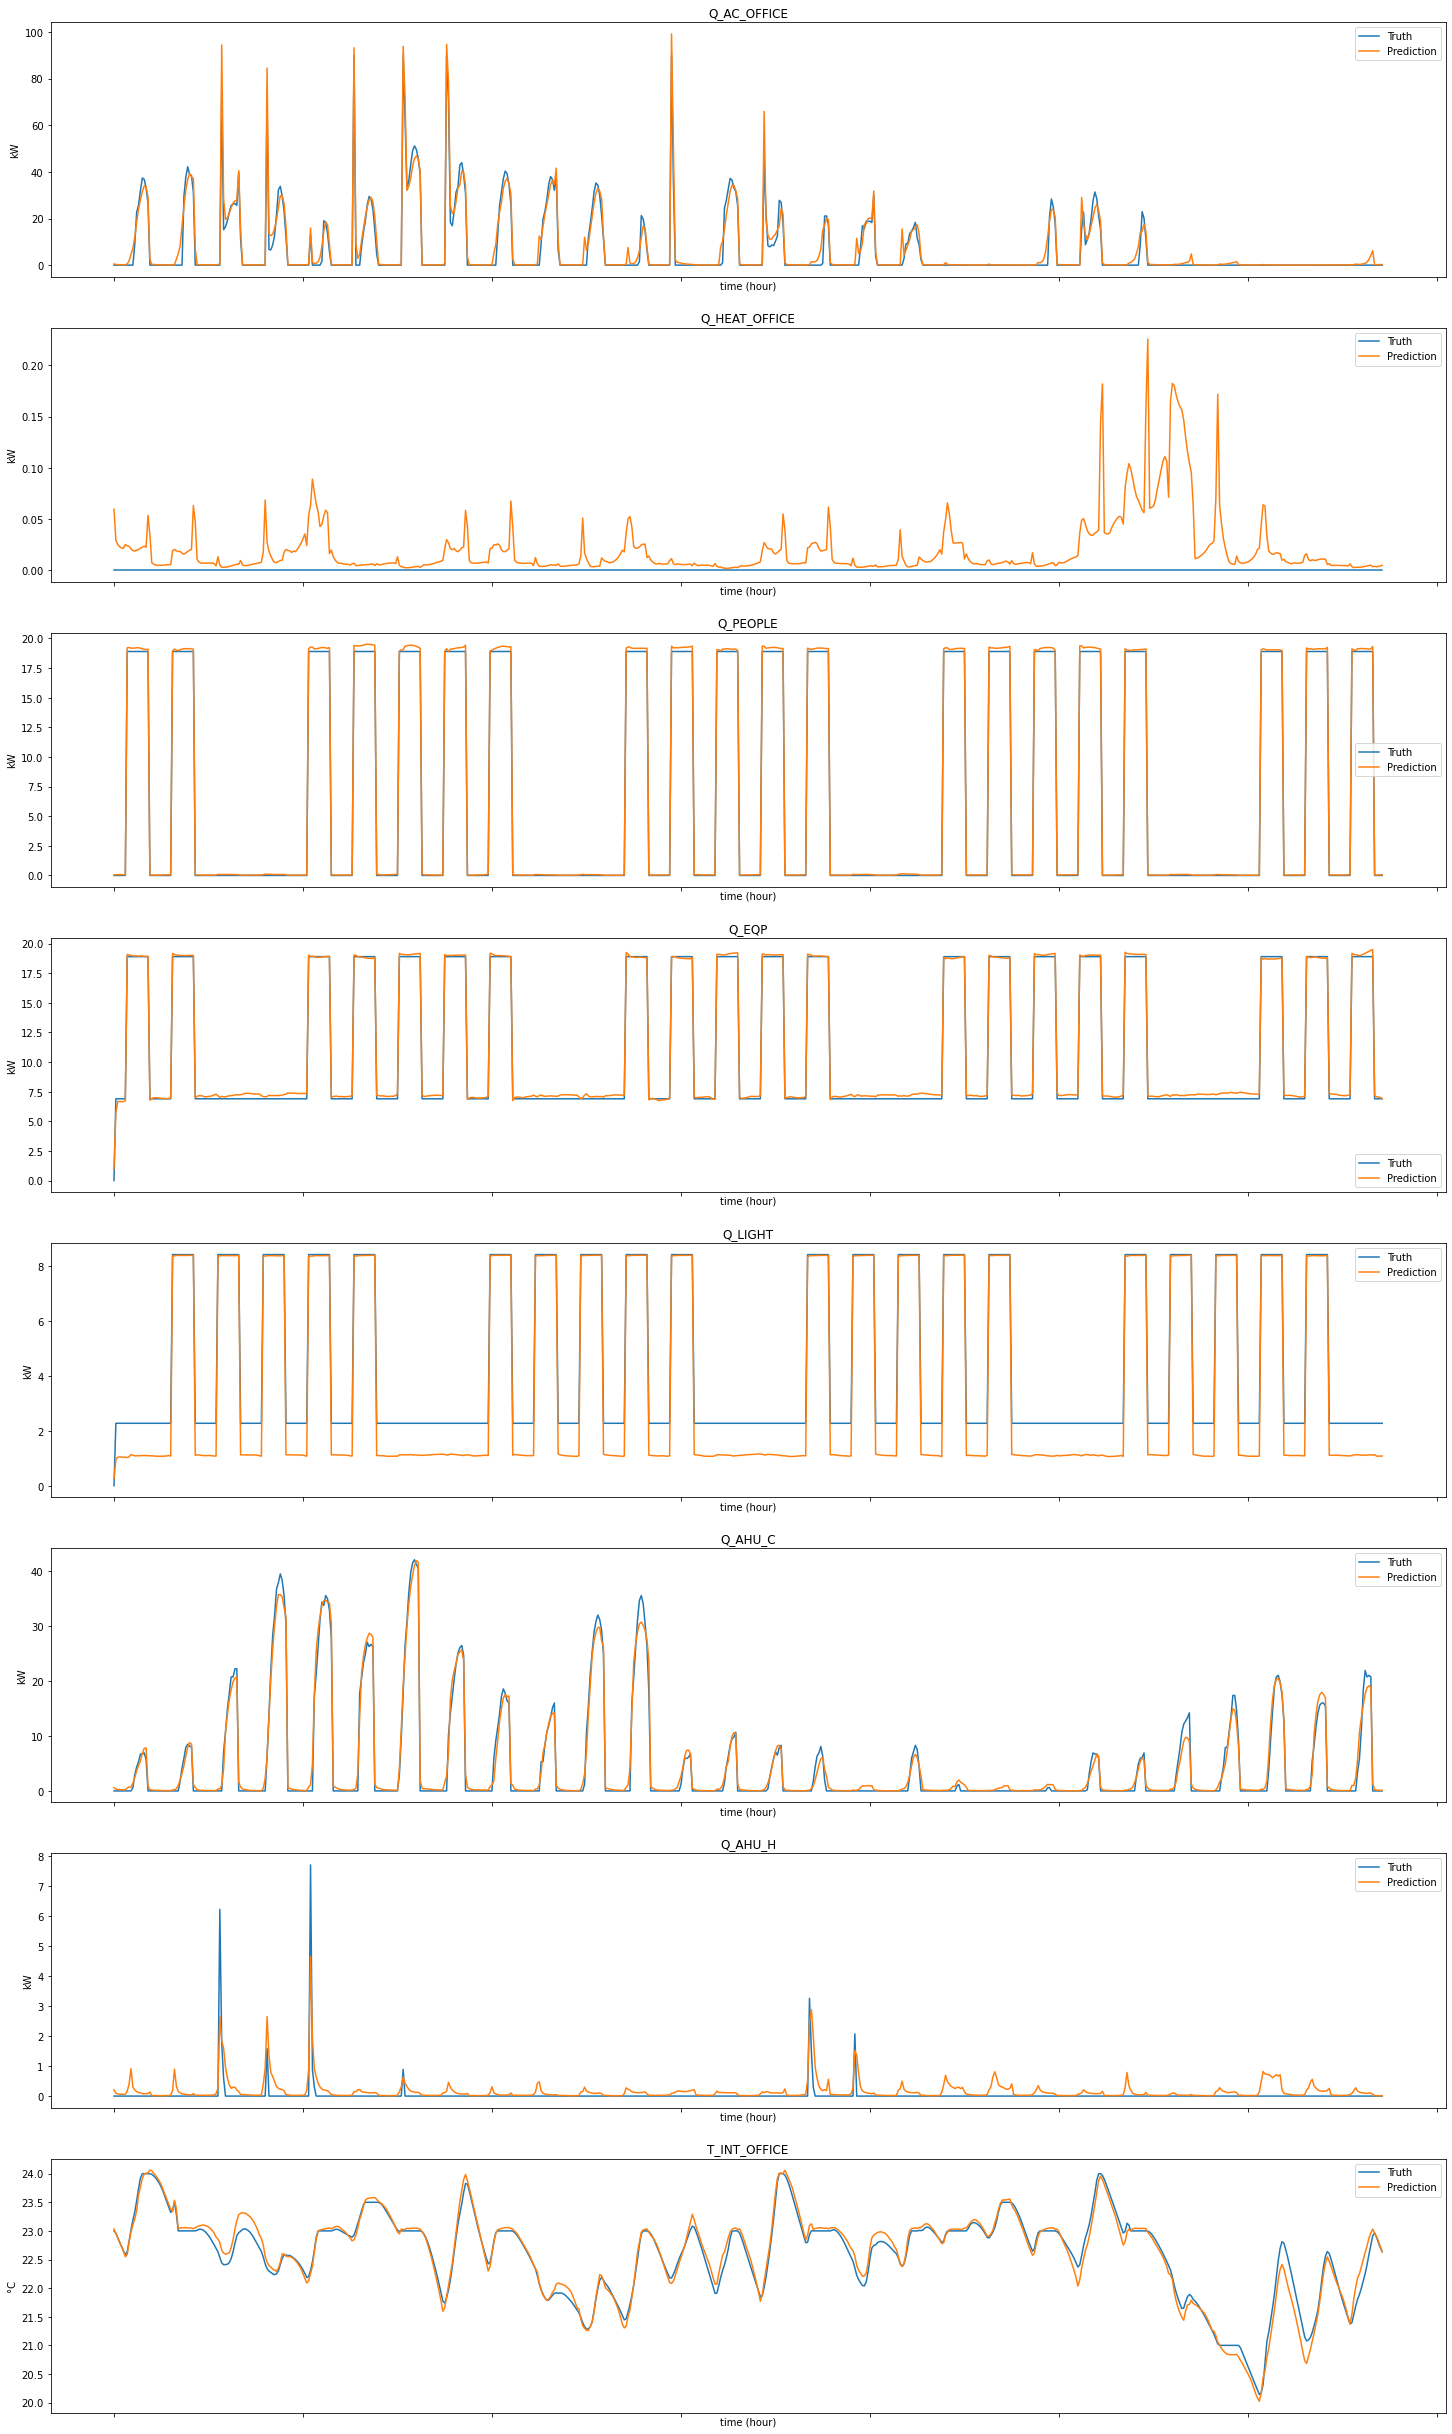

In [43]:
map_plot_function(ozeDataset, predictions, plot_visual_sample, dataset_indices=dataloader_test.dataset.indices)

### Plot results on a sample

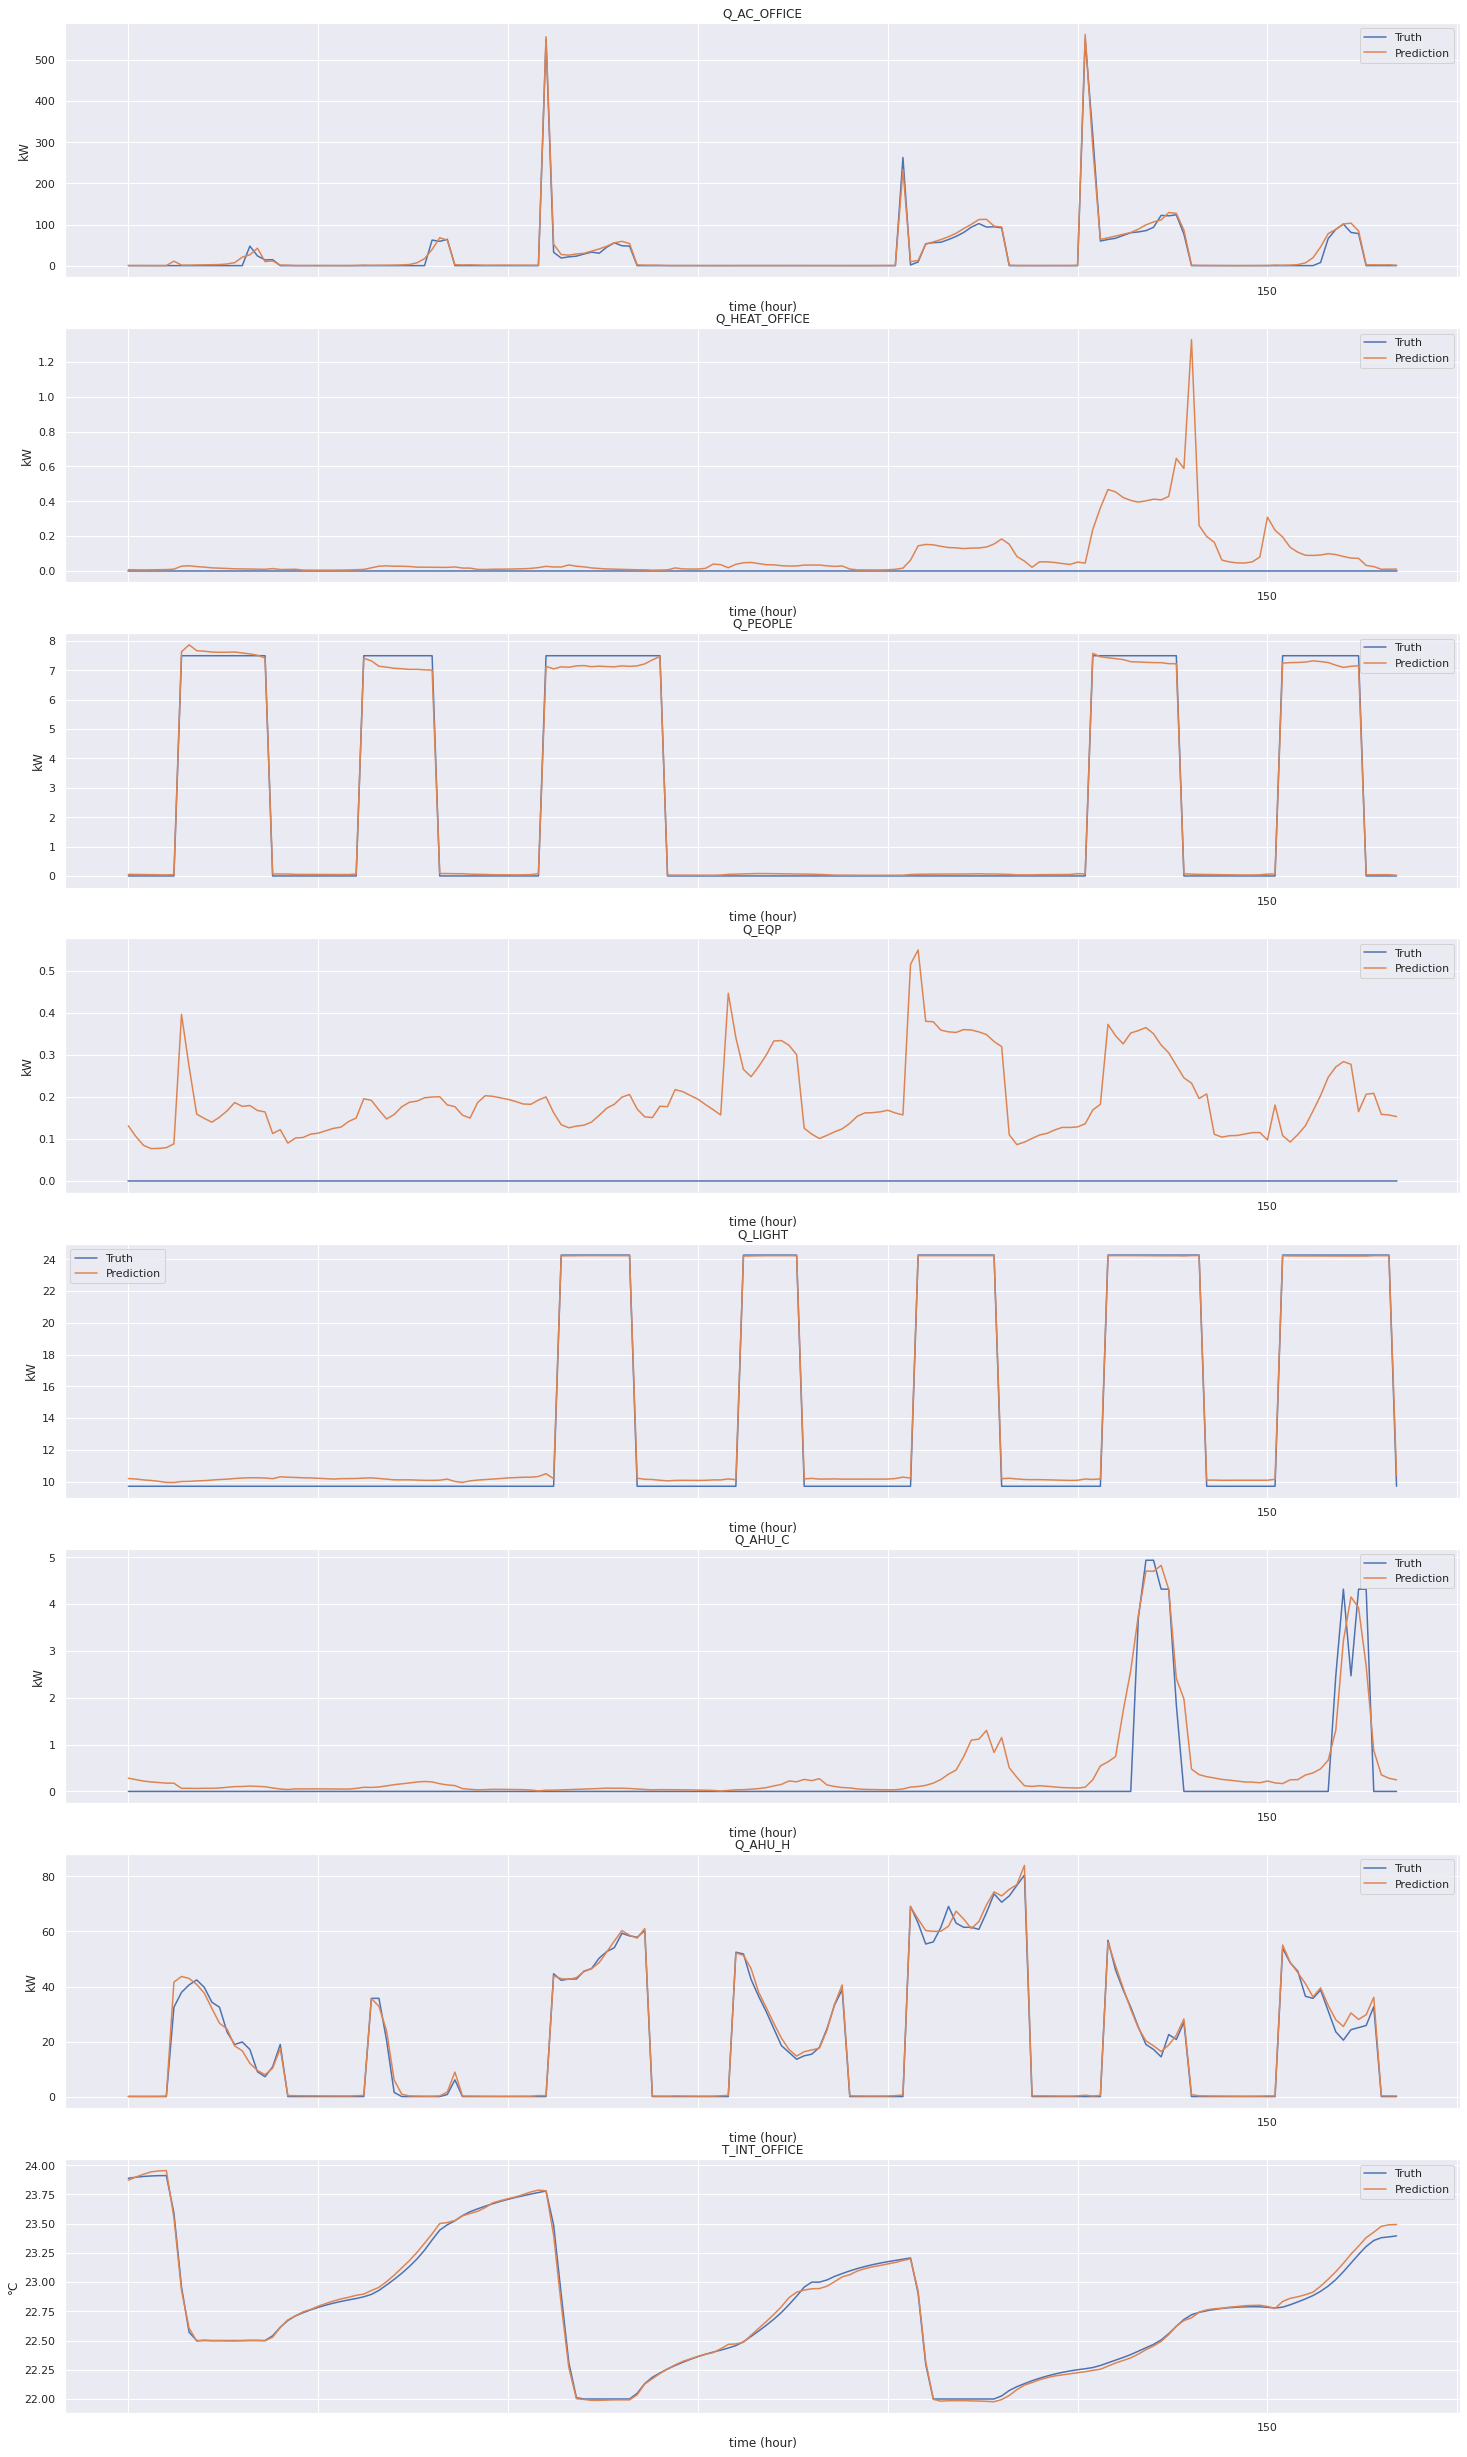

In [9]:
map_plot_function(ozeDataset, predictions, plot_visual_sample, dataset_indices=dataloader_test.dataset.indices)

### Plot error distributions

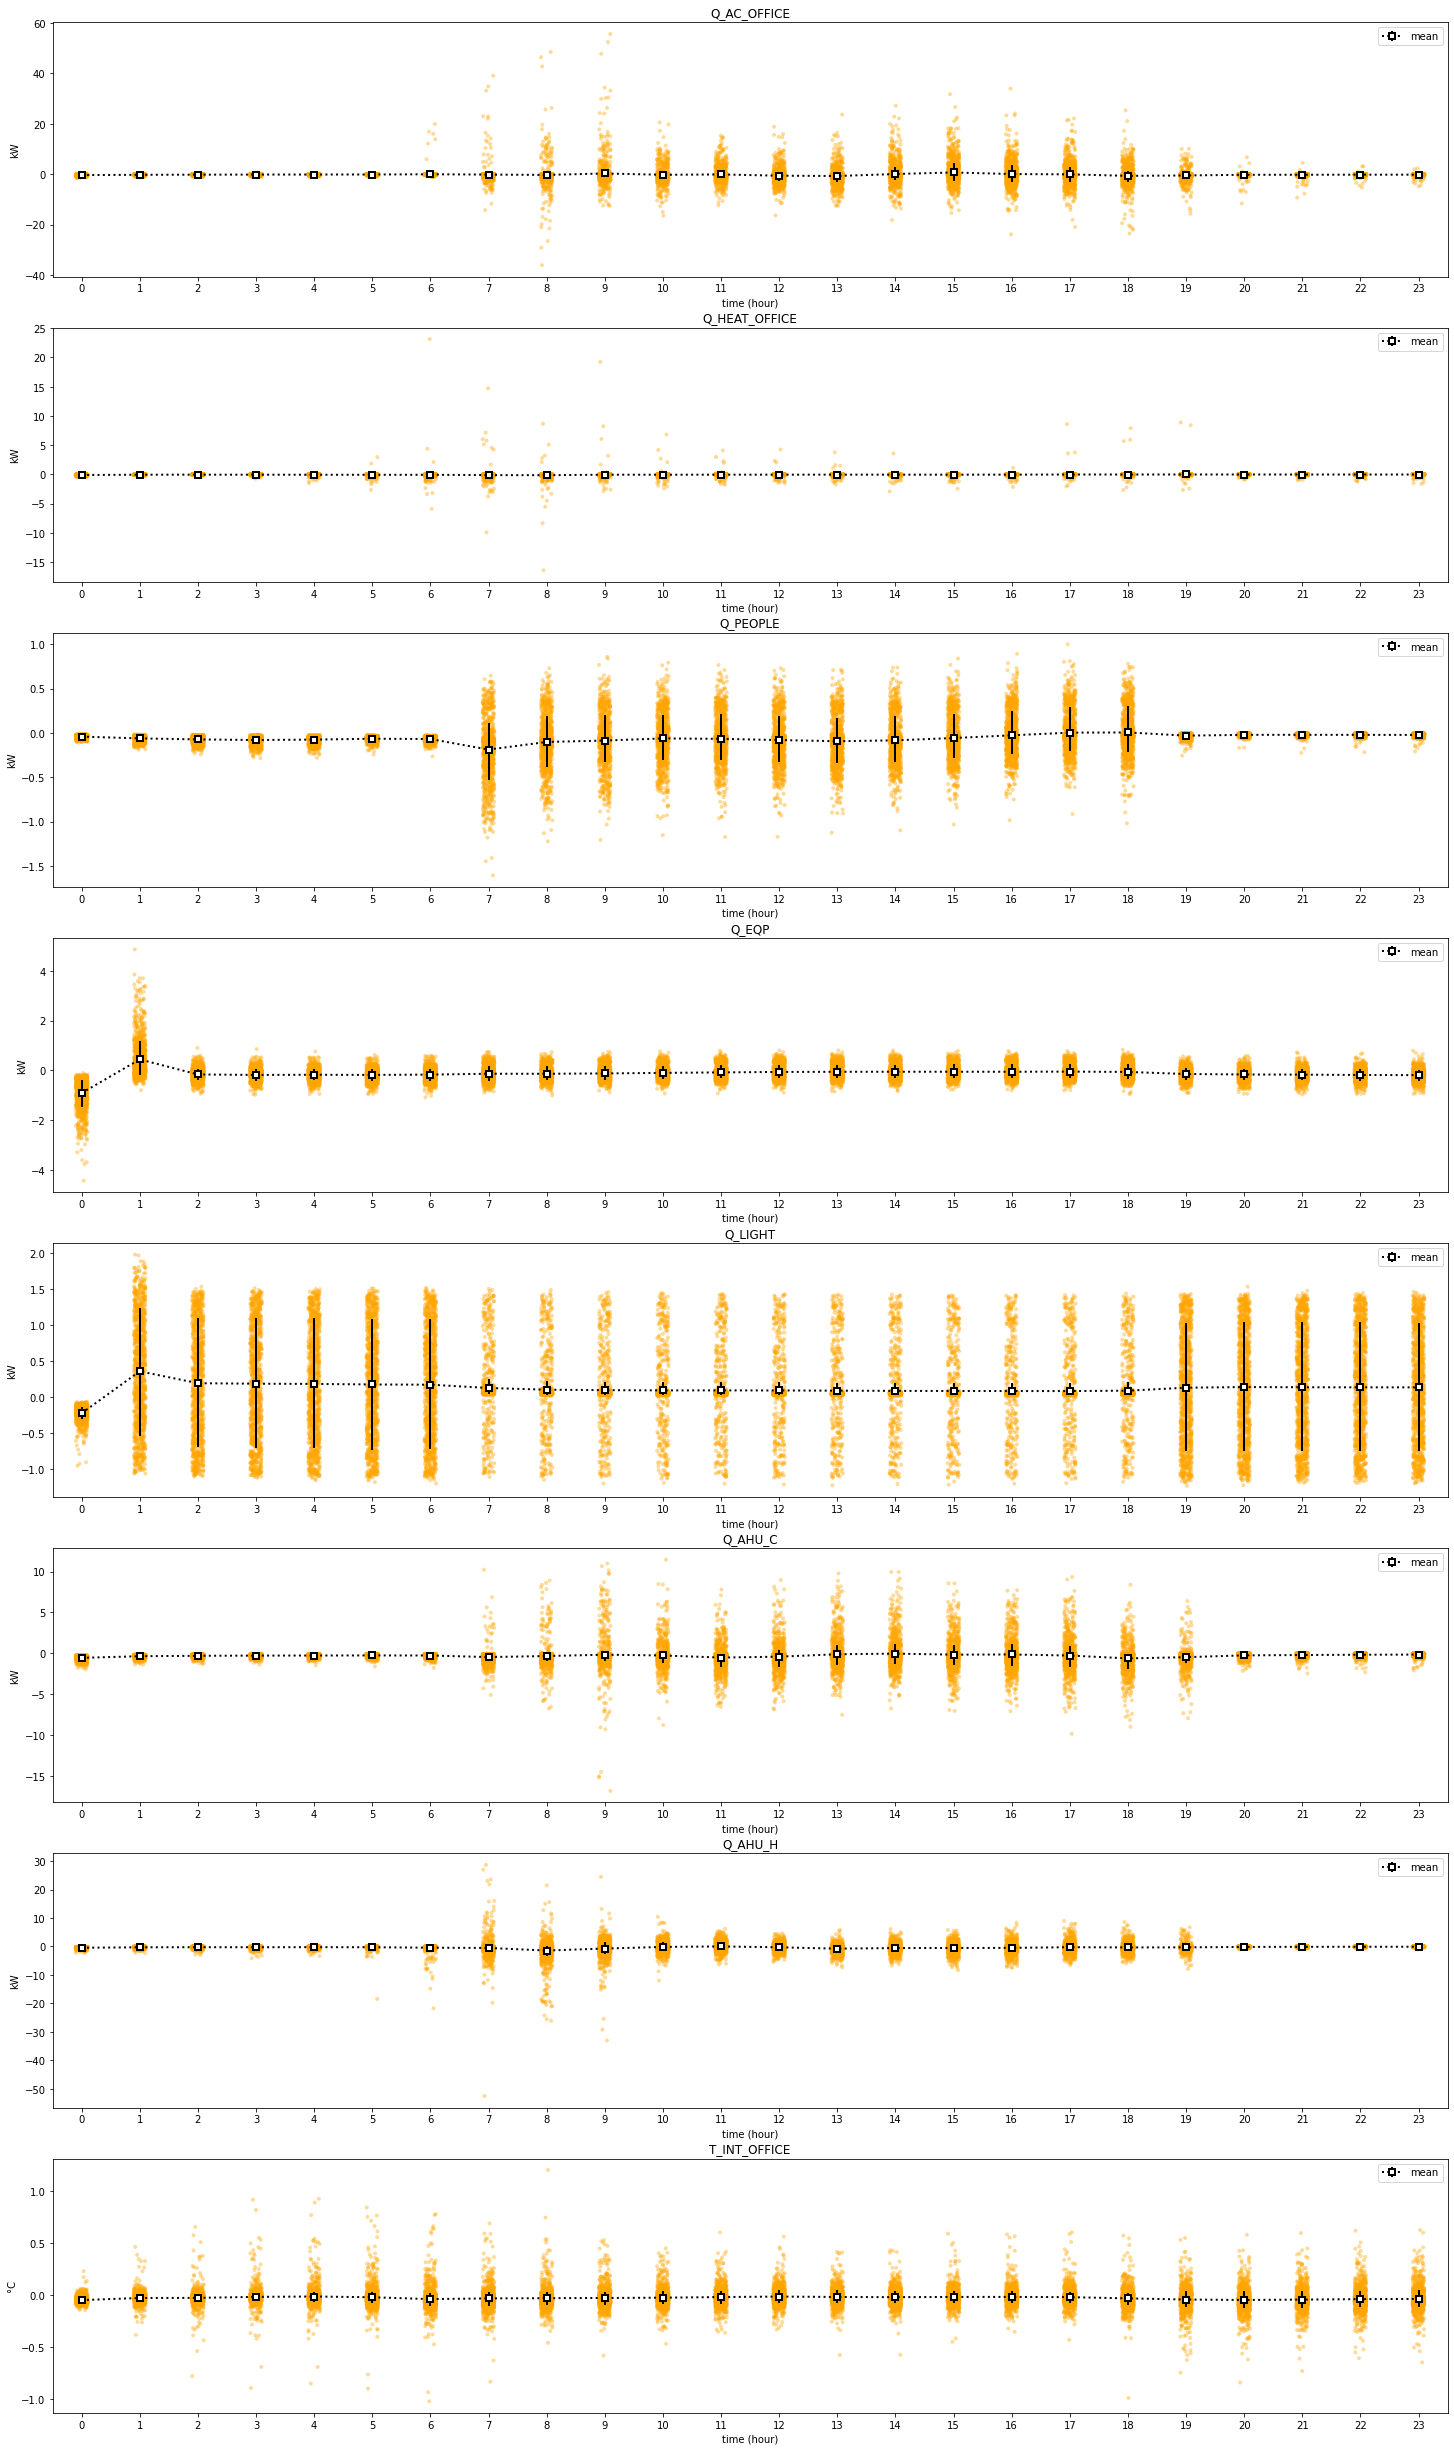

In [44]:
map_plot_function(ozeDataset, predictions, plot_error_distribution,
                  dataset_indices=dataloader_test.dataset.indices, time_limit=24)

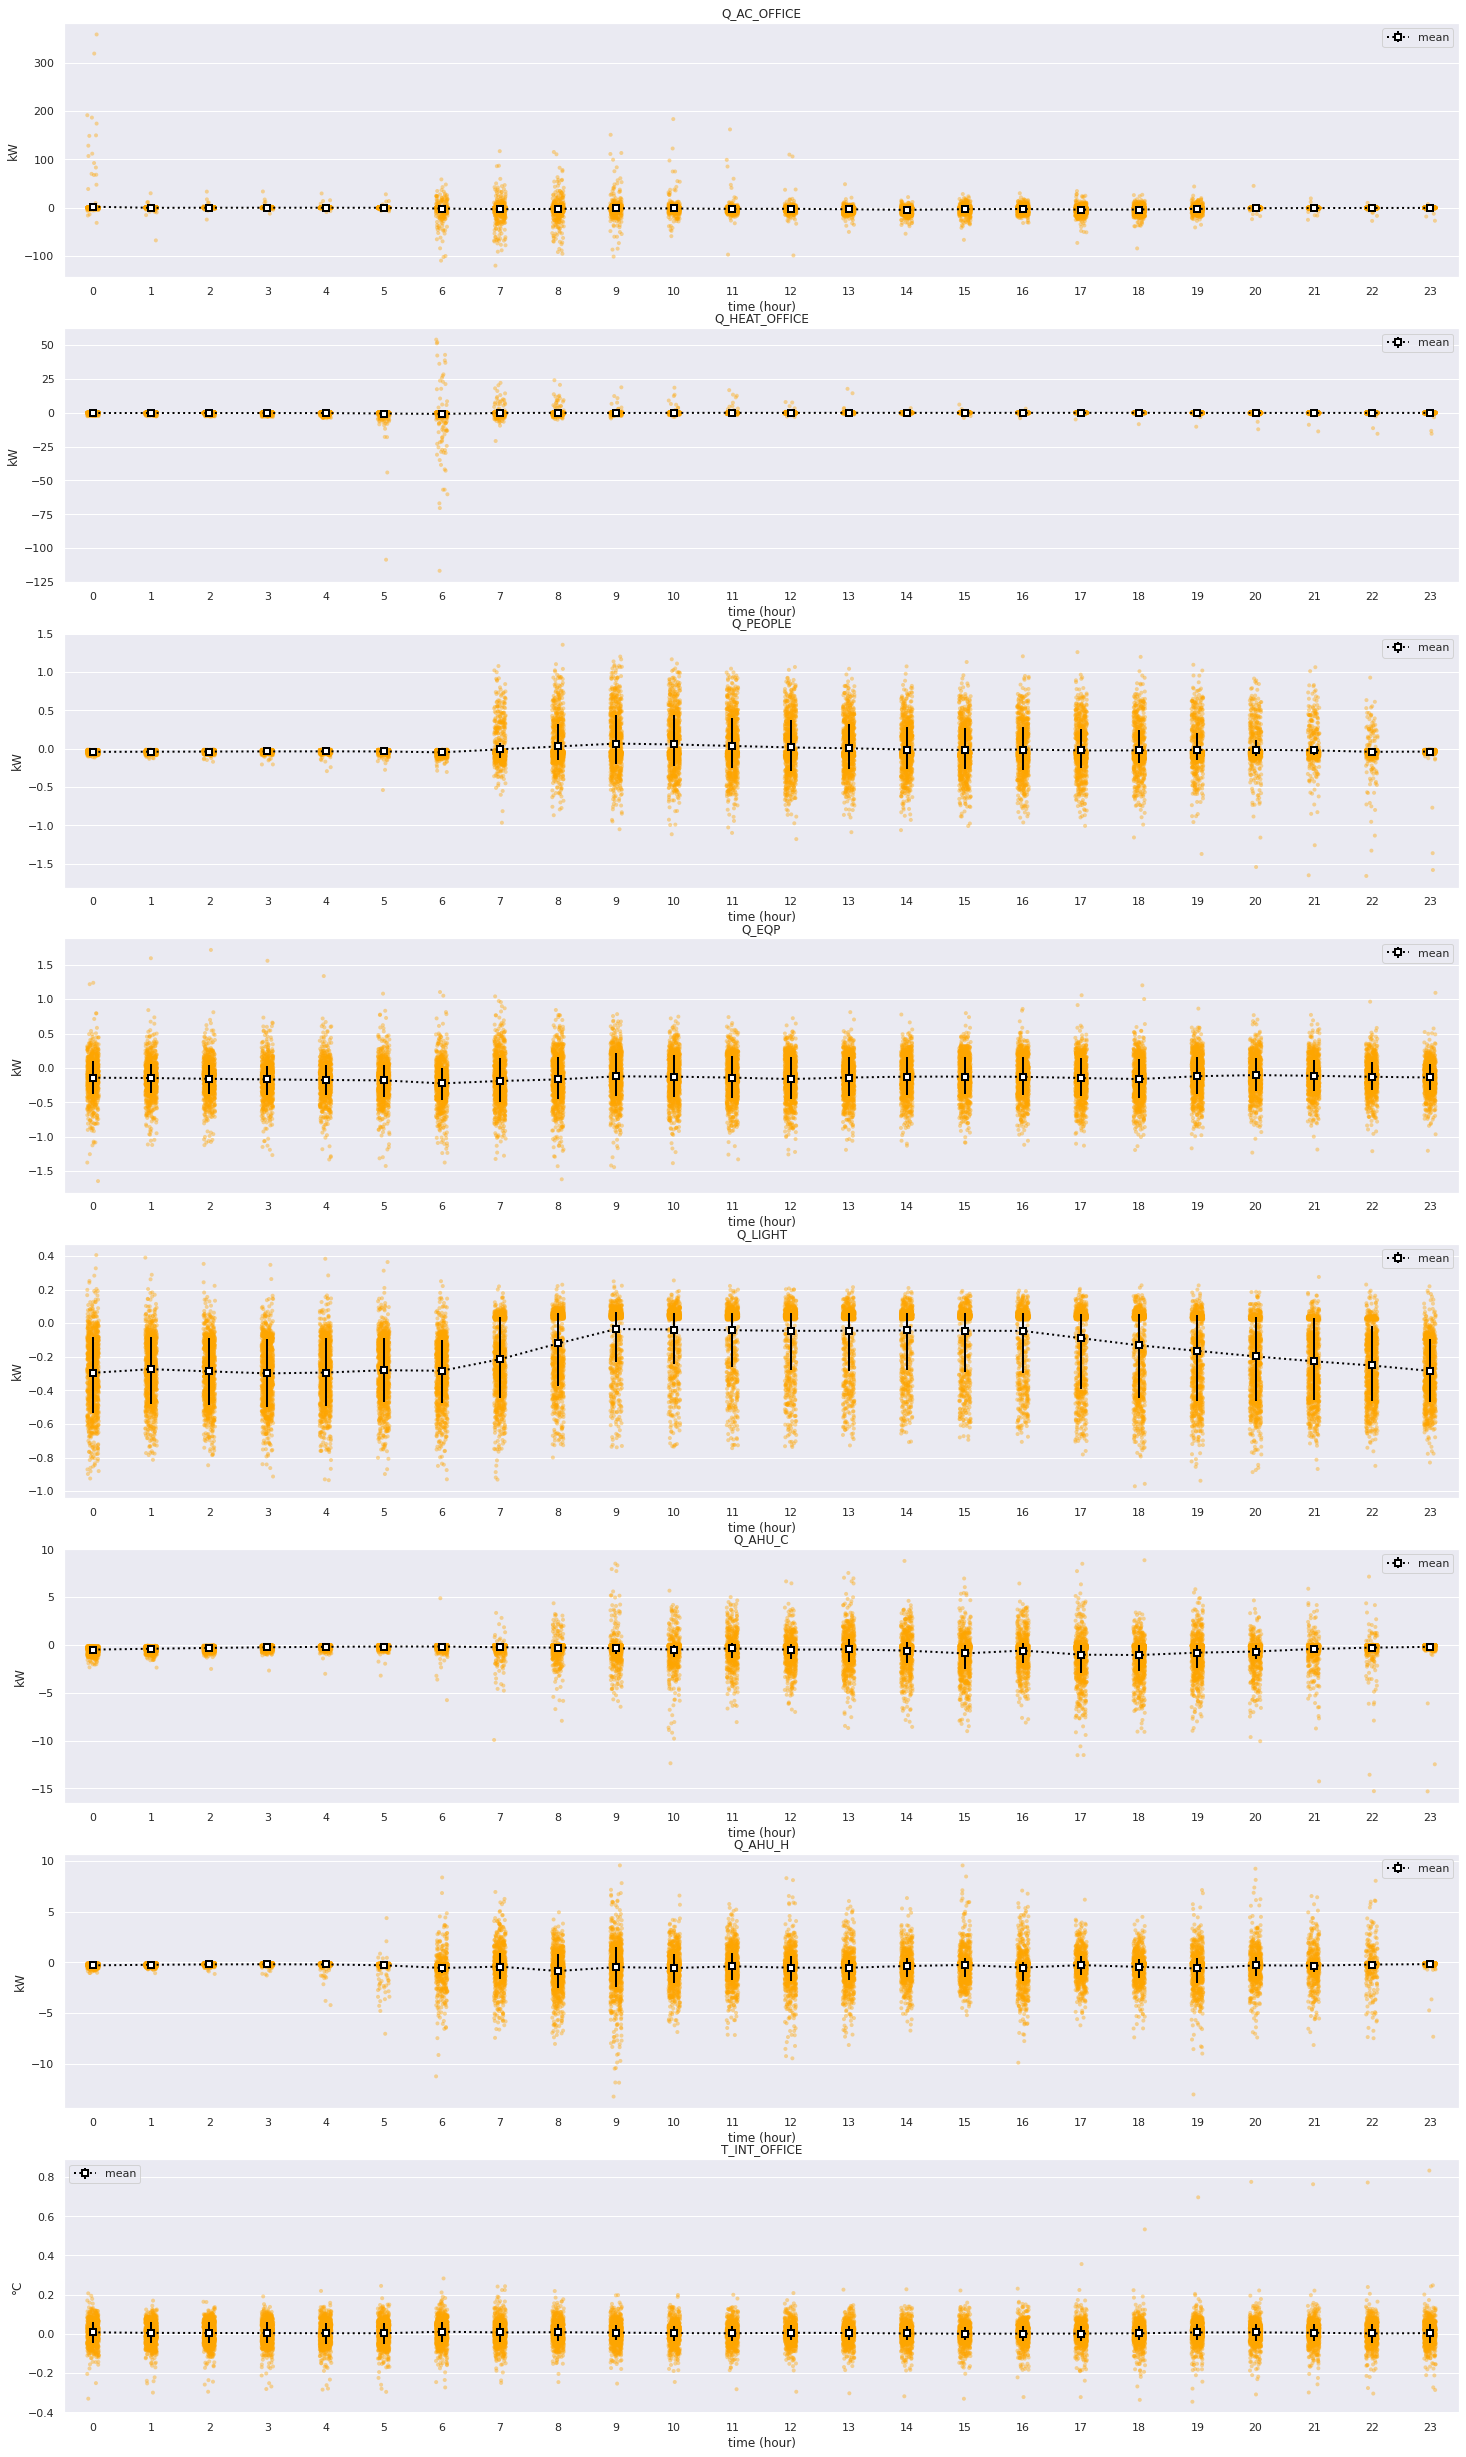

In [10]:
map_plot_function(ozeDataset, predictions, plot_error_distribution, dataset_indices=dataloader_test.dataset.indices, time_limit=24)

### Plot mispredictions thresholds

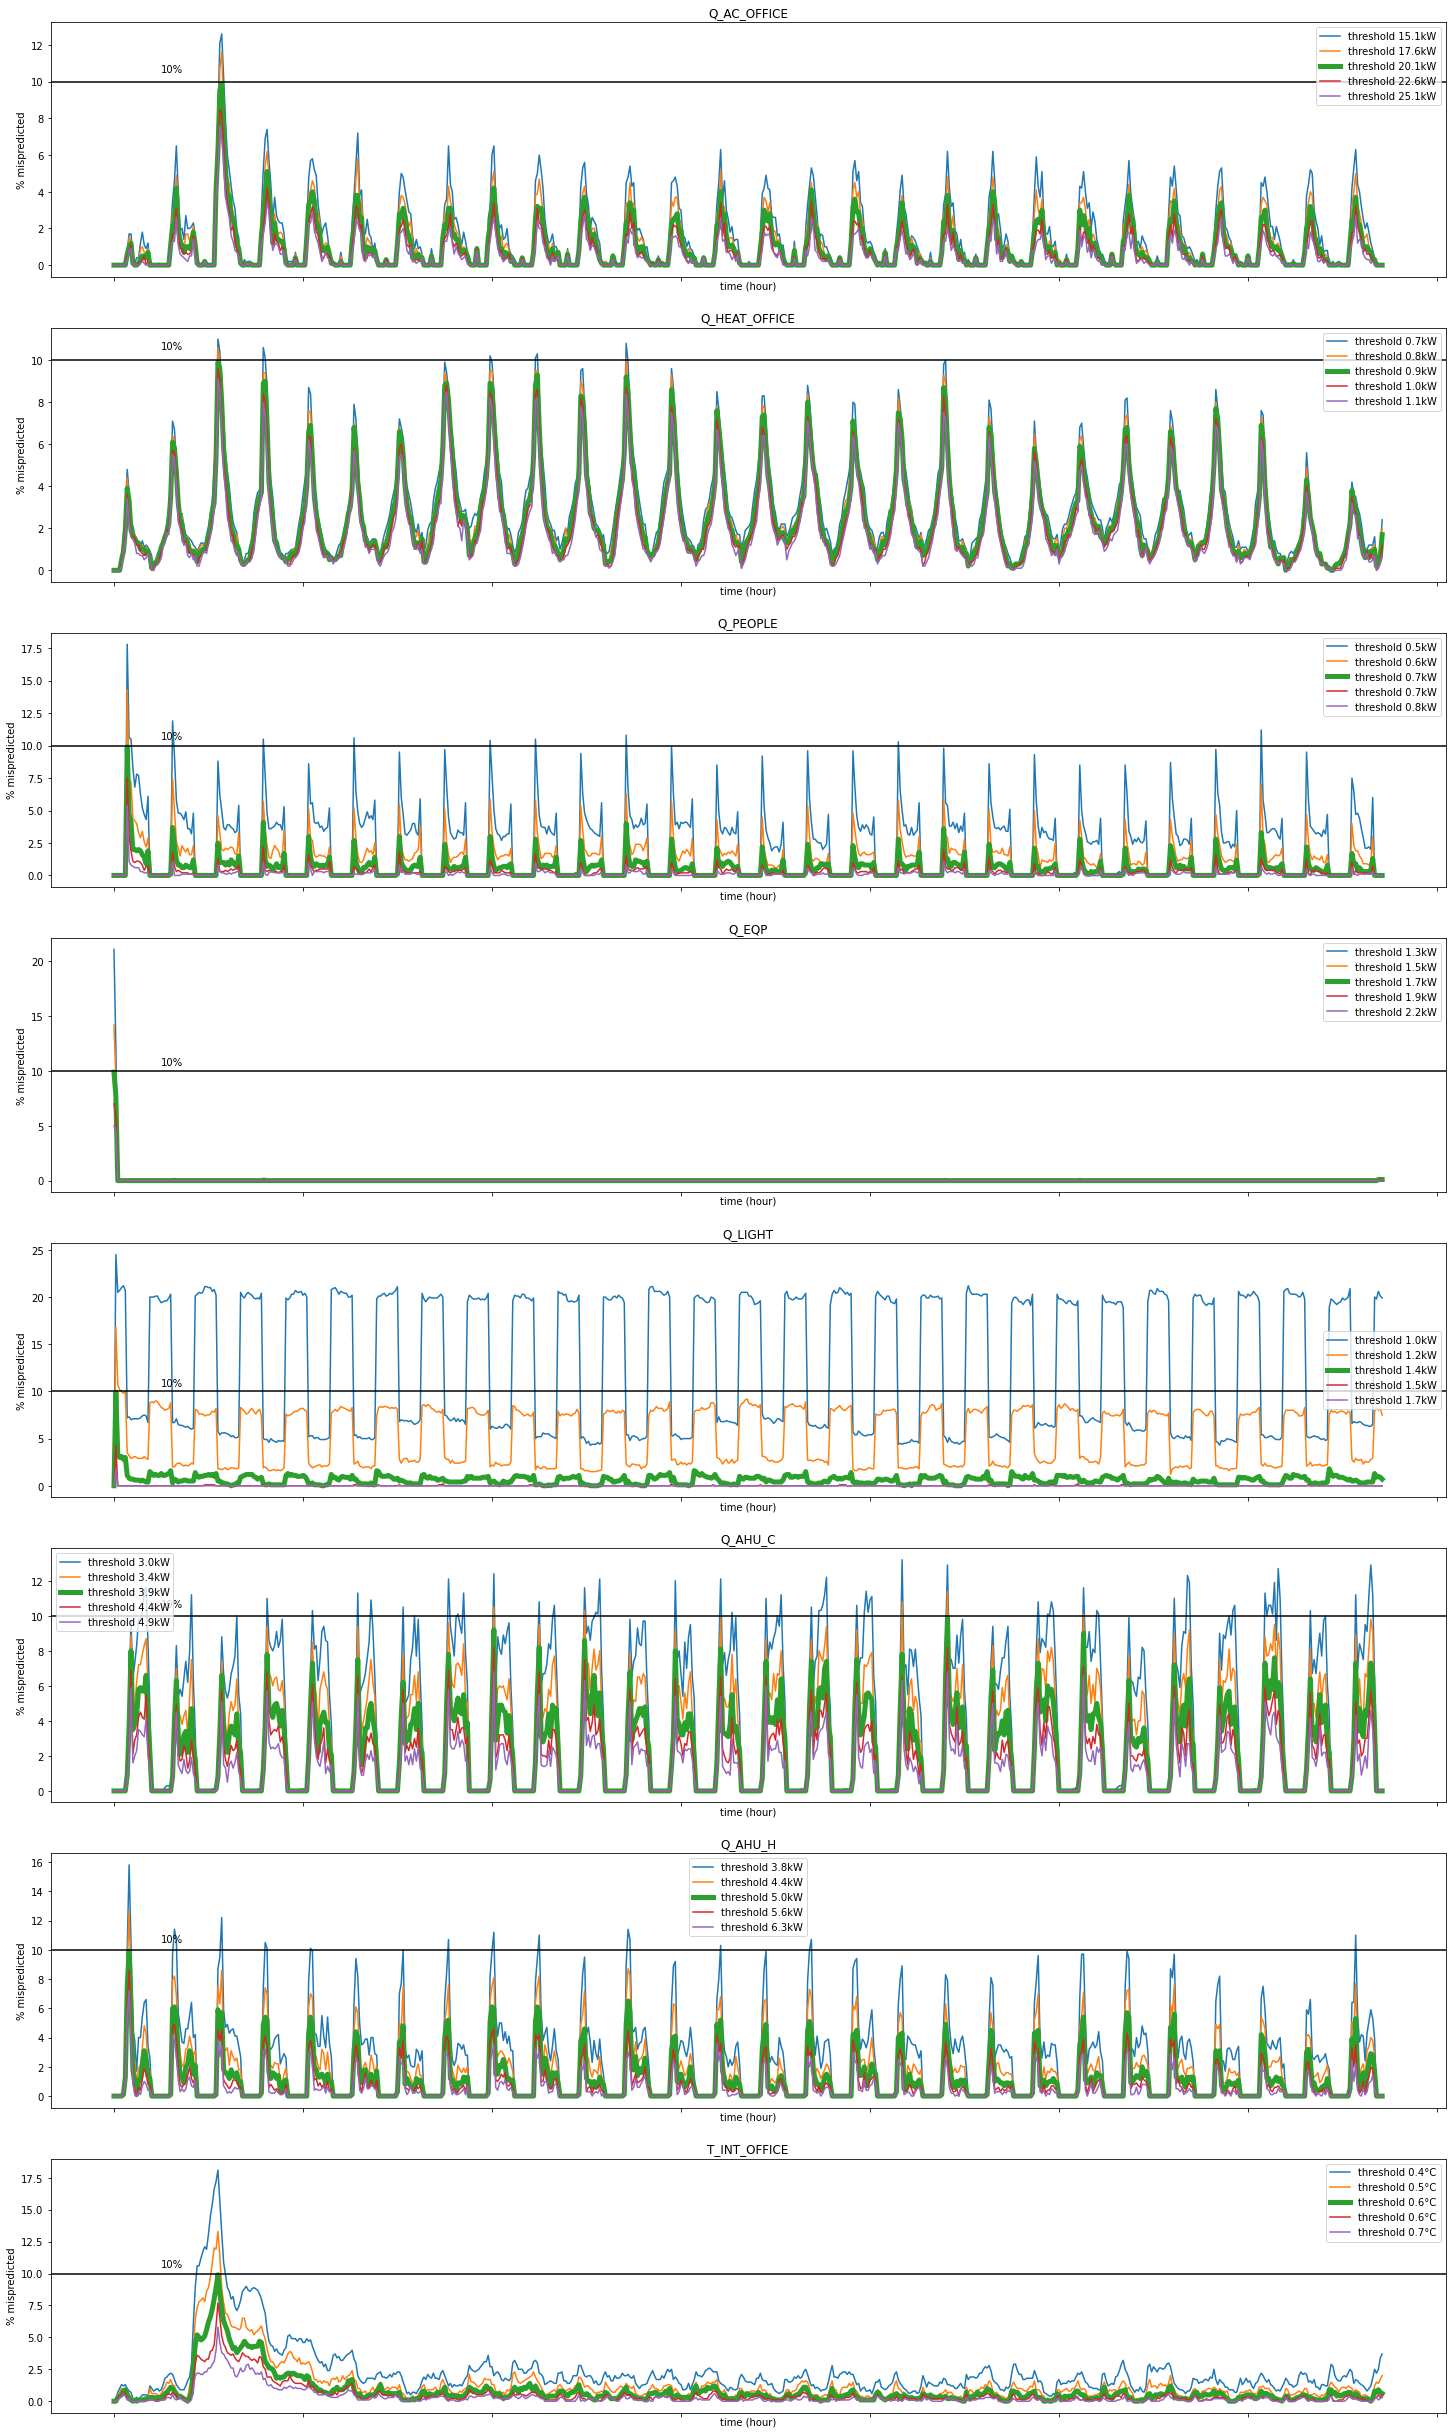

In [45]:
map_plot_function(ozeDataset, predictions, plot_errors_threshold, 
                  plot_kwargs={'error_band': 0.1}, dataset_indices=dataloader_test.dataset.indices)

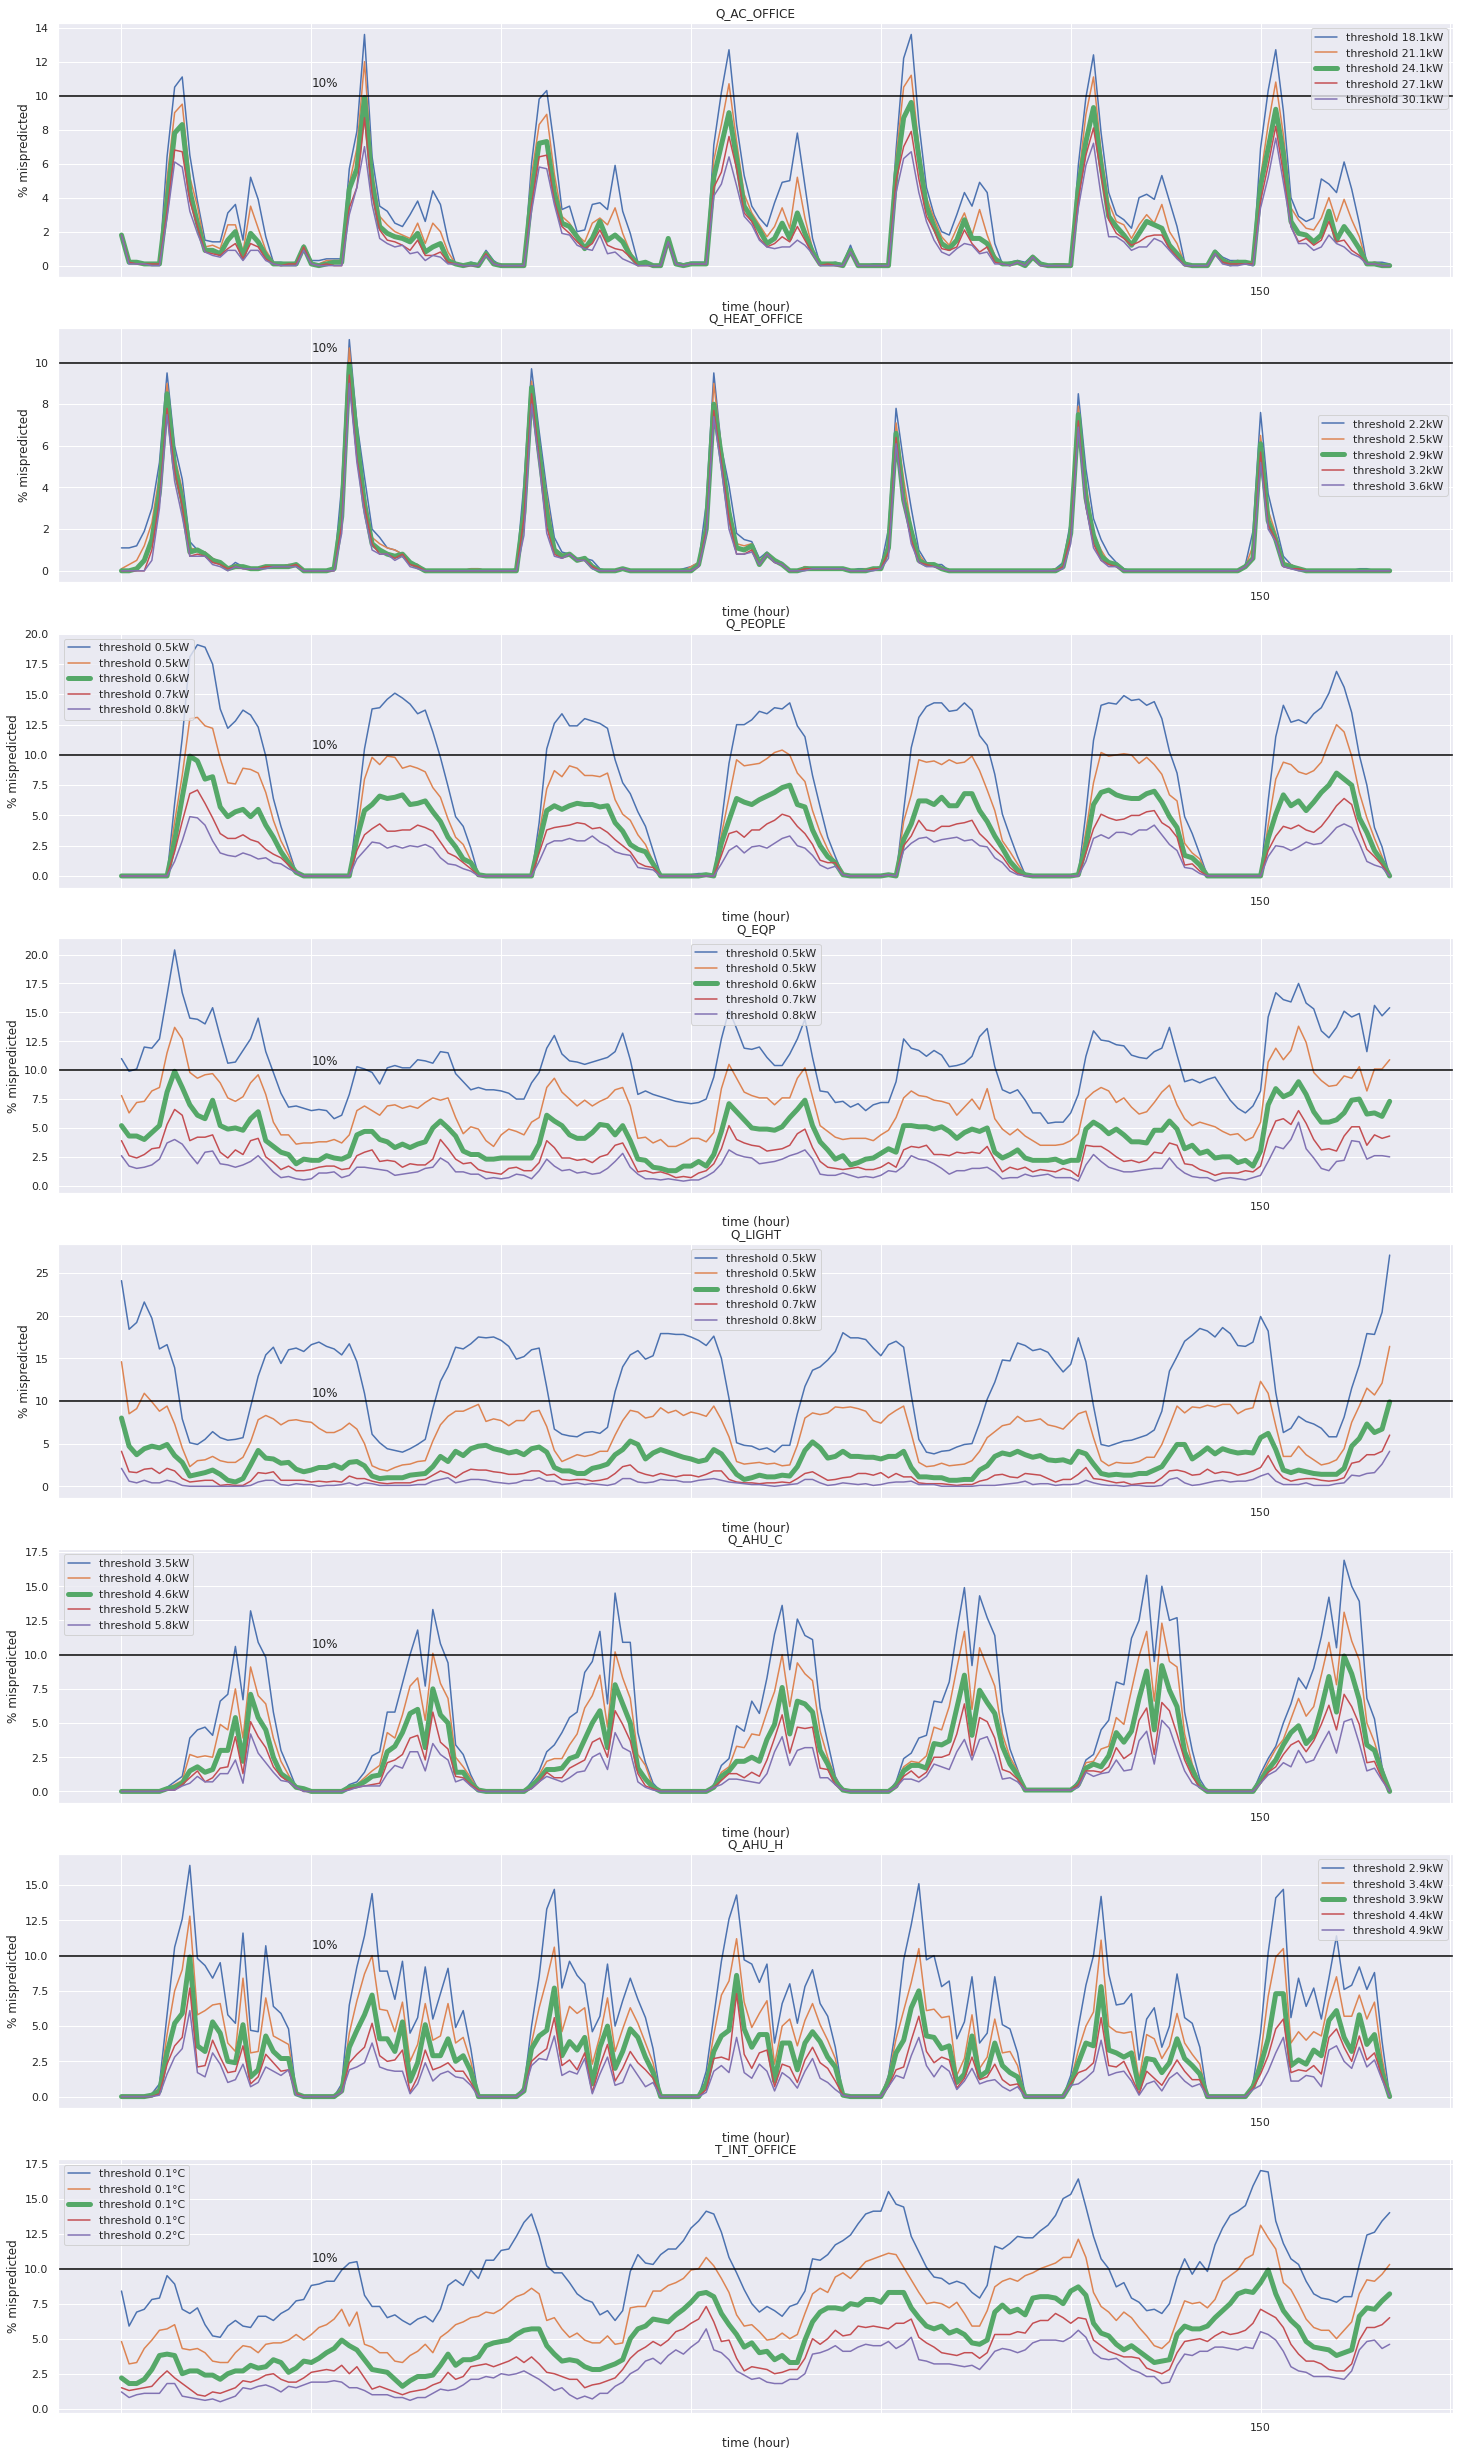

In [11]:
map_plot_function(ozeDataset, predictions, plot_errors_threshold, plot_kwargs={'error_band': 0.1}, dataset_indices=dataloader_test.dataset.indices)